In [1]:
#importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Importing NLTK packages
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer as tf
from collections import Counter
from wordcloud import WordCloud

#Importing warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#importing the train csv file
data=pd.read_excel(r'C:\Users\satvi\OneDrive\Desktop\ratings prediction.xlsx')
data.head()

,Unnamed: 0,Ratings,Short Review,Full Review
0,0,5,Fabulous!,"i loved it, superb performance, awesome batter..."
1,1,5,Super!,I wonder why nobody posted pics for snow white...
2,2,5,Classy product,Very compact design and very stylish look I'm ...
3,3,5,Just wow!,An amazing device especially for high & smooth...
4,4,4,Pretty good,Received it yesterday.\n\nIt has a 100% plasti...


In [3]:
#checking for the shape of the dataset
data.shape

(20568, 4)

In [4]:
#Checking for nulls
data.isnull().sum()

Unnamed: 0       0
Ratings         11
Short Review     1
Full Review      6
dtype: int64

In [5]:
#Getting the top 10 samples
data.sample(10)

,Unnamed: 0,Ratings,Short Review,Full Review
19214,19214,1.0 out of 5 stars,"Don't buy this. It never worked, and seller sa...",Perfect printer to take on a road trip. My wif...
14271,14271,1,Best in the market!,nice
11909,11909,1,Good Quality..,Best in Class\nGo for It
4662,4662,4,Good quality product,Fist thing which i want to make clear that don...
2167,2167,4,Just wow!,Excellent phone at this price range.... Recomm...
12995,12995,5,Best in the market!,Packing was great\nLucky i didn't get a defect...
1756,1756,4,Brilliant,Good handy phone with decent performance. Good...
5732,5732,5,Awesome,I bought this bluetooth headset as i am very f...
4575,4575,5,Great product,It comes in a small container which is easy to...
6144,6144,5,Must buy!,I almost returned this as i couldn't get it to...


<AxesSubplot:>

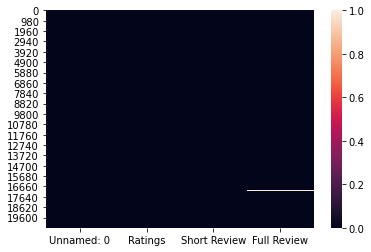

In [6]:
#Visualising the nulls using heatmap
sns.heatmap(data.isnull())

In [7]:
#Checking for dtypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20568 entries, 0 to 20567
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    20568 non-null  int64 
 1   Ratings       20557 non-null  object
 2   Short Review  20567 non-null  object
 3   Full Review   20562 non-null  object
dtypes: int64(1), object(3)
memory usage: 642.9+ KB


In [8]:
#Filling the null values
data['Ratings']=data['Ratings'].fillna(data['Ratings'].mode()[0])
data['Short Review']=data['Short Review'].fillna(data['Short Review'].mode()[0])
data['Full Review']=data['Full Review'].fillna(data['Full Review'].mode()[0])

In [9]:
#Checking for null after filling
data.isnull().sum()

Unnamed: 0      0
Ratings         0
Short Review    0
Full Review     0
dtype: int64

In [10]:
#Dropping the columns which are not required for our analysis 
data.drop(columns=['Unnamed: 0','Short Review'],axis=1,inplace=True)

In [11]:
data['Ratings'].value_counts()

5                     10496
4                      3436
5.0 out of 5 stars     1799
1                      1423
3                      1104
1.0 out of 5 stars      809
4.0 out of 5 stars      488
2                       475
3.0 out of 5 stars      289
2.0 out of 5 stars      243
1                         3
5                         2
4                         1
Name: Ratings, dtype: int64

### Feature Engineering

In [12]:
#Replacing the repeated classes 
data['Ratings']=data['Ratings'].replace(['5.0 out of 5 stars','1.0 out of 5 stars','4.0 out of 5 stars','3.0 out of 5 stars','2.0 out of 5 stars',5,4,3,2,1],[5,1,4,3,2,5,4,3,2,1])

In [13]:
#Checking for count values of ratings
data['Ratings'].value_counts()

5    12297
4     3925
1     2235
3     1393
2      718
Name: Ratings, dtype: int64

<AxesSubplot:xlabel='Ratings', ylabel='count'>

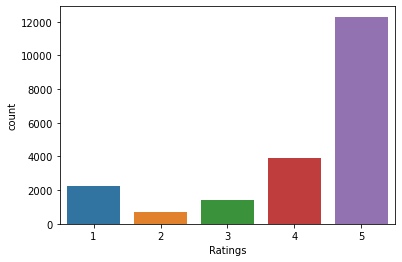

In [14]:
#Plotting the countplot to check how the data is distributed in the ratings column
sns.countplot(data['Ratings'])

In [15]:
# Let us look at the word count in the review text
data['word_count'] = data['Full Review'].apply(lambda x: len(str(x).split(" ")))
data[['Full Review','word_count']].head()

,Full Review,word_count
0,"i loved it, superb performance, awesome batter...",29
1,I wonder why nobody posted pics for snow white...,88
2,Very compact design and very stylish look I'm ...,19
3,An amazing device especially for high & smooth...,25
4,Received it yesterday.\n\nIt has a 100% plasti...,94


In [16]:
# Let us look at the character count in the review text
data['char_count'] = data['Full Review'].str.len() ## this also includes spaces
data[['Full Review','char_count']].head()

,Full Review,char_count
0,"i loved it, superb performance, awesome batter...",163
1,I wonder why nobody posted pics for snow white...,500
2,Very compact design and very stylish look I'm ...,104
3,An amazing device especially for high & smooth...,152
4,Received it yesterday.\n\nIt has a 100% plasti...,499


In [17]:
# Let us look at the average word length in the review text sentence
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

data['avg_word'] = data['Full Review'].apply(lambda x: avg_word(x))
data[['Full Review','avg_word']].head()
data['Full Review'][10]

'Battery life could be better , on normal usage it is lasting around 8-9 hours , display is very good , extremely light weight. Performance is as expected from intel , blazing fast , fingerprint, windows Hello works like charm .'

In [18]:
# Let us look if there is any text that starts with hashtags
data['hashtags'] = data['Full Review'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
data[['Full Review','hashtags']].head()

,Full Review,hashtags
0,"i loved it, superb performance, awesome batter...",0
1,I wonder why nobody posted pics for snow white...,0
2,Very compact design and very stylish look I'm ...,0
3,An amazing device especially for high & smooth...,0
4,Received it yesterday.\n\nIt has a 100% plasti...,0


In [19]:
# Let us look at the count of stopwords present in the review text
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['stopwords'] = data['Full Review'].apply(lambda x: len([x for x in x.split() if x in stop]))
data[['Full Review','stopwords']].head()

,Full Review,stopwords
0,"i loved it, superb performance, awesome batter...",11
1,I wonder why nobody posted pics for snow white...,31
2,Very compact design and very stylish look I'm ...,4
3,An amazing device especially for high & smooth...,3
4,Received it yesterday.\n\nIt has a 100% plasti...,41


In [20]:
# Let us look at the count of numerics present in the review text
data['numerics'] = data['Full Review'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
data[['Full Review','numerics']].head()

,Full Review,numerics
0,"i loved it, superb performance, awesome batter...",0
1,I wonder why nobody posted pics for snow white...,0
2,Very compact design and very stylish look I'm ...,0
3,An amazing device especially for high & smooth...,0
4,Received it yesterday.\n\nIt has a 100% plasti...,2


In [21]:
# Let us look at the top 10 frequent words
freq_top = pd.Series(' '.join(data['Full Review']).split()).value_counts()[:10]
freq_top

the     33847
and     27003
is      26965
to      21975
I       21069
a       19268
for     14872
it      13769
this    12992
of      11897
dtype: int64

In [22]:
# Let us look at the least 10 frequent words
freq_least = pd.Series(' '.join(data['Full Review']).split()).value_counts()[-10:]
freq_least

con?             1
DSLRs.           1
fate.            1
product.....i    1
bajara           1
pinch-to-open    1
nonpainful       1
closed-backs     1
low).            1
copying.         1
dtype: int64

In [23]:
# Let us include the text length column in review dataset
data['text length'] = data['Full Review'].apply(len)
data.head()

,Ratings,Full Review,word_count,char_count,avg_word,hashtags,stopwords,numerics,text length
0,5,"i loved it, superb performance, awesome batter...",29,163,4.655172,0,11,0,163
1,5,I wonder why nobody posted pics for snow white...,88,500,4.693182,0,31,0,500
2,5,Very compact design and very stylish look I'm ...,19,104,4.526316,0,4,0,104
3,5,An amazing device especially for high & smooth...,25,152,5.120000,0,3,0,152
4,4,Received it yesterday.\n\nIt has a 100% plasti...,94,499,4.252632,0,41,2,499


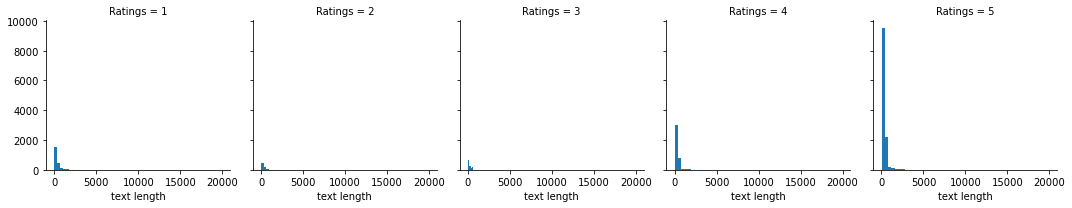

In [24]:
# Lets visualise the review text and stars for a business
g = sns.FacetGrid(data=data, col='Ratings')
g.map(plt.hist, 'text length', bins=50)

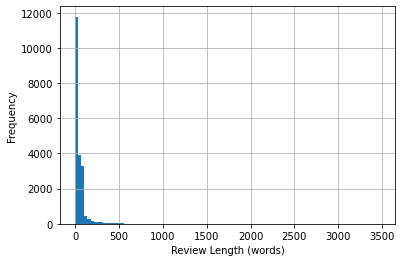

In [25]:
## Getting the number of words by splitting them by a space
words_per_review = data['Full Review'].apply(lambda x: len(x.split(" ")))
words_per_review.hist(bins = 100)
plt.xlabel('Review Length (words)')
plt.ylabel('Frequency')
plt.show()


In [26]:
#checking for average words present in the reviews text and finding how much skewness present in the text
print('Average words:', words_per_review.mean())
print('Skewness:', words_per_review.skew())

Average words: 52.38934266822248
Skewness: 11.705363563598876


In [27]:
#Checking how much pecentage of different ratings given by the users
percent_val = 100 * data['Ratings'].value_counts()/len(data) #calculating the percentage of ratings 
percent_val

5    59.787048
4    19.083042
1    10.866394
3     6.772657
2     3.490860
Name: Ratings, dtype: float64

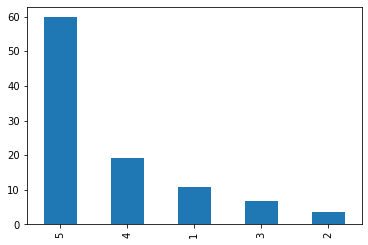

In [28]:
#plotting the bar graph on percentage of ratings distribution in the ratings column
percent_val.plot.bar()
plt.show()

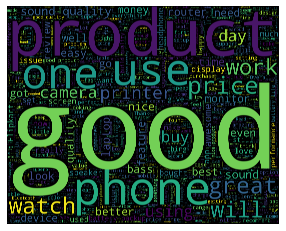

In [29]:
# Wordcloud for visualising most used words
word_cloud_text = ''.join(data['Full Review'])

wordcloud = WordCloud(max_font_size=1000, # Maximum font size for the largest word
                      max_words=4000, # The maximum number of words
                      background_color="black", # Background color for the word cloud image
                      scale = 10, # Scaling between computation and drawing
                      width=1000, # Width of the canvas
                      height=1000 # Height of the canvas
                     ).generate(word_cloud_text)

plt.figure()
plt.imshow(wordcloud, 
           interpolation="bilinear") # to make the displayed image appear more smoothly
plt.axis("off")
plt.show()

In [31]:
#Lowering the cases of the reviews
data['Full Review new'] = data['Full Review'].str.lower()

In [32]:
# For reviews not converted to lowe case
token_lists = [word_tokenize(each) for each in data['Full Review']]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens then: ",len(set(tokens)))

# For reviews converted to lowe case
token_lists_lower = [word_tokenize(each) for each in data['Full Review new']]
tokens_lower = [item for sublist in token_lists_lower for item in sublist]
print("Number of unique tokens now: ",len(set(tokens_lower)))

Number of unique tokens then:  41545
Number of unique tokens now:  34493


In [33]:
### Selecting non alpha numeric charactes that are not spaces
spl_chars = data['Full Review new'].apply(lambda review: 
                                                     [char for char in list(review) if not char.isalnum() and char != ' '])

## Getting list of list into a single list
flat_list = [item for sublist in spl_chars for item in sublist]

## Unique special characters
set(flat_list)

{'\n',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~',
 '¡',
 '£',
 '«',
 '°',
 '¶',
 '»',
 '¿',
 '×',
 '،',
 'ं',
 'ु',
 '\u200d',
 '–',
 '—',
 '‘',
 '’',
 '“',
 '”',
 '„',
 '•',
 '…',
 '€',
 '₵',
 '₹',
 '™',
 '→',
 '⌚',
 '⏩',
 '■',
 '▶',
 '►',
 '◀',
 '●',
 '◡',
 '◾',
 '☀',
 '★',
 '☆',
 '☝',
 '☹',
 '☺',
 '♂',
 '♥',
 '⚙',
 '⚡',
 '⚪',
 '⚫',
 '✅',
 '✌',
 '✍',
 '✓',
 '✔',
 '✖',
 '✨',
 '❌',
 '❣',
 '❤',
 '➡',
 '⭐',
 '、',
 '。',
 '️',
 '（',
 '）',
 '＋',
 '，',
 '？',
 '･',
 '🅰',
 '🅱',
 '🅳',
 '🅴',
 '🅸',
 '🅻',
 '🅿',
 '🆁',
 '🆂',
 '🆃',
 '🆅',
 '🆈',
 '🆗',
 '🇮',
 '🇳',
 '🌋',
 '🌚',
 '🌟',
 '🌱',
 '🌷',
 '🌹',
 '🌼',
 '🎆',
 '🎈',
 '🎉',
 '🎊',
 '🎖',
 '🎚',
 '🎤',
 '🎧',
 '🎬',
 '🎭',
 '🎮',
 '🎵',
 '🎶',
 '🎼',
 '🏆',
 '🏘',
 '🏠',
 '🏡',
 '🏻',
 '🏼',
 '🏽',
 '🏾',
 '🏿',
 '🐷',
 '🐼',
 '👂',
 '👈',
 '👉',
 '👊',
 '👌',
 '👍',
 '👎',
 '👏',
 '👑',
 '👖',
 '👣',
 '👫',
 '👹',
 '💀',
 '💊',
 '💌',
 '💎',
 '💐',
 '💑

In [34]:
#Replacing the strings present the reviews column
review_backup = data['Full Review new'].copy()
data['Full Review new'] = data['Full Review new'].str.replace(r'[^A-Za-z0-9 ]+', ' ')

In [35]:
#Printing the review before and after removing the strings from text
print("- Old Review -")#before
print(review_backup.values[6])
print("\n- New Review -")#after
print(data['Full Review'][6])

- Old Review -
best for
1. online classes , zoom meetings, browsing and the reason is because of its portability, excellent battery life but the camera quality is just average for video conferences.
2. you may not get the best typing experience but better than many windows devices which is almost twice the price.
3. chrome os is light weight and also supports android apps. google will definitely comes with better desktop experience in future. it also providing updates till 2028
4. build quality is fine fo...

- New Review -
Best for
1. Online classes , Zoom meetings, browsing and the reason is because of its portability, excellent battery life but the camera quality is just average for video conferences.
2. You may not get the best typing experience but better than many windows devices which is almost twice the price.
3. Chrome OS is light weight and also supports Android Apps. Google will definitely comes with better desktop experience in future. It also providing updates till 2028
4.

In [36]:
#Applying tokenization for converting the text to words and getting the number of unique words present in the text
token_lists = [word_tokenize(each) for each in data['Full Review']]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens then: ",len(set(tokens)))

token_lists = [word_tokenize(each) for each in data['Full Review new']]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens now: ",len(set(tokens)))

Number of unique tokens then:  41545
Number of unique tokens now:  28132


In [37]:
#getting the stopwords present in the nltk library
noise_words = []
eng_stop_words = stopwords.words('english')
eng_stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [38]:
#Checking for stop words present in the text
stop_words = set(stopwords.words('english'))
without_stop_words = []
stopword = []
sentence = data['Full Review new'][0]
words = nltk.word_tokenize(sentence)

for word in words:
    if word in stop_words:
        stopword.append(word)
    else:
        without_stop_words.append(word)

print('-- Original Sentence --\n', sentence)
print('\n-- Stopwords in the sentence --\n', stopword)
print('\n-- Non-stopwords in the sentence --\n', without_stop_words)

-- Original Sentence --
 i loved it  superb performance  awesome battery and touch is just wow  this is a complete package  design is also premium and build is also premium  loved it  

-- Stopwords in the sentence --
 ['i', 'it', 'and', 'is', 'just', 'this', 'is', 'a', 'is', 'and', 'is', 'it']

-- Non-stopwords in the sentence --
 ['loved', 'superb', 'performance', 'awesome', 'battery', 'touch', 'wow', 'complete', 'package', 'design', 'also', 'premium', 'build', 'also', 'premium', 'loved']


In [39]:
#Removing the stop words from the reviews
def stopwords_removal(stop_words, sentence):
    return [word for word in nltk.word_tokenize(sentence) if word not in stop_words]

data['reviews_text_nonstop'] = data['Full Review new'].apply(lambda row: stopwords_removal(stop_words, row))
data[['Full Review new','reviews_text_nonstop']]

,Full Review new,reviews_text_nonstop
0,i loved it superb performance awesome batter...,"[loved, superb, performance, awesome, battery,..."
1,i wonder why nobody posted pics for snow white...,"[wonder, nobody, posted, pics, snow, white, va..."
2,very compact design and very stylish look i m ...,"[compact, design, stylish, look, really, like,..."
3,an amazing device especially for high smooth...,"[amazing, device, especially, high, smooth, pe..."
4,received it yesterday it has a 100 plastic bo...,"[received, yesterday, 100, plastic, body, touc..."
...,...,...
20563,i lovingly call this router the wopr based on...,"[lovingly, call, router, wopr, based, movie, w..."
20564,first let me say that i ve installed several ...,"[first, let, say, installed, several, hundred,..."
20565,i intentionally waited a month before reviewin...,"[intentionally, waited, month, reviewing, rout..."
20566,compr el ac5400 porque el sistema provisto po...,"[compr, el, ac5400, porque, el, sistema, provi..."


In [40]:
#Checking how stemmetization gives the words and lemmatization gives the words 
from nltk.stem import PorterStemmer, LancasterStemmer # Common stemmers
from nltk.stem import WordNetLemmatizer # Common Lematizer
nltk.download('wordnet')
from nltk.corpus import wordnet

porter = PorterStemmer()
lancaster = LancasterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\satvi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [41]:
#applying stemmertization and lemmatization on the text
def stemm_terms(row):
    return [lancaster.stem(term) for term in row]
def lemmatize_terms(row):
    return [lemmatizer.lemmatize(term) for term in row]
    
data['reviews_text_stemm'] =data['reviews_text_nonstop'].apply(lambda row: stemm_terms(row))
data['reviews_text_lemm'] = data['reviews_text_nonstop'].apply(lambda row: lemmatize_terms(row))
data[['reviews_text_nonstop','reviews_text_stemm','reviews_text_lemm']]

,reviews_text_nonstop,reviews_text_stemm,reviews_text_lemm
0,"[loved, superb, performance, awesome, battery,...","[lov, superb, perform, awesom, battery, touch,...","[loved, superb, performance, awesome, battery,..."
1,"[wonder, nobody, posted, pics, snow, white, va...","[wond, nobody, post, pic, snow, whit, vary, lo...","[wonder, nobody, posted, pic, snow, white, var..."
2,"[compact, design, stylish, look, really, like,...","[compact, design, styl, look, real, lik, produ...","[compact, design, stylish, look, really, like,..."
3,"[amazing, device, especially, high, smooth, pe...","[amaz, dev, espec, high, smoo, perform, onlin,...","[amazing, device, especially, high, smooth, pe..."
4,"[received, yesterday, 100, plastic, body, touc...","[receiv, yesterday, 100, plast, body, touchscr...","[received, yesterday, 100, plastic, body, touc..."
...,...,...,...
20563,"[lovingly, call, router, wopr, based, movie, w...","[lov, cal, rout, wopr, bas, movy, war, gam, ma...","[lovingly, call, router, wopr, based, movie, w..."
20564,"[first, let, say, installed, several, hundred,...","[first, let, say, instal, sev, hundr, rout, ye...","[first, let, say, installed, several, hundred,..."
20565,"[intentionally, waited, month, reviewing, rout...","[int, wait, mon, review, rout, got, deal, day,...","[intentionally, waited, month, reviewing, rout..."
20566,"[compr, el, ac5400, porque, el, sistema, provi...","[compr, el, ac5400, porqu, el, sistem, provist...","[compr, el, ac5400, porque, el, sistema, provi..."


In [42]:
#checking the head method
data.head()

,Ratings,Full Review,word_count,char_count,avg_word,hashtags,stopwords,numerics,text length,Full Review new,reviews_text_nonstop,reviews_text_stemm,reviews_text_lemm
0,5,"i loved it, superb performance, awesome batter...",29,163,4.655172,0,11,0,163,i loved it superb performance awesome batter...,"[loved, superb, performance, awesome, battery,...","[lov, superb, perform, awesom, battery, touch,...","[loved, superb, performance, awesome, battery,..."
1,5,I wonder why nobody posted pics for snow white...,88,500,4.693182,0,31,0,500,i wonder why nobody posted pics for snow white...,"[wonder, nobody, posted, pics, snow, white, va...","[wond, nobody, post, pic, snow, whit, vary, lo...","[wonder, nobody, posted, pic, snow, white, var..."
2,5,Very compact design and very stylish look I'm ...,19,104,4.526316,0,4,0,104,very compact design and very stylish look i m ...,"[compact, design, stylish, look, really, like,...","[compact, design, styl, look, real, lik, produ...","[compact, design, stylish, look, really, like,..."
3,5,An amazing device especially for high & smooth...,25,152,5.120000,0,3,0,152,an amazing device especially for high smooth...,"[amazing, device, especially, high, smooth, pe...","[amaz, dev, espec, high, smoo, perform, onlin,...","[amazing, device, especially, high, smooth, pe..."
4,4,Received it yesterday.\n\nIt has a 100% plasti...,94,499,4.252632,0,41,2,499,received it yesterday it has a 100 plastic bo...,"[received, yesterday, 100, plastic, body, touc...","[receiv, yesterday, 100, plast, body, touchscr...","[received, yesterday, 100, plastic, body, touc..."


In [43]:
### Creating a python object of the class CountVectorizer
tfidf_counts = tf(tokenizer= word_tokenize, # type of tokenization
                               stop_words=noise_words, # List of stopwords
                               max_features=5000,min_df=0,ngram_range=(1,2)) # number of n-grams

tfidf_data = tfidf_counts.fit_transform(data['Full Review new'])
tfidf_data

<20568x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 1010339 stored elements in Compressed Sparse Row format>

In [44]:
x=tfidf_data
y=data['Ratings']

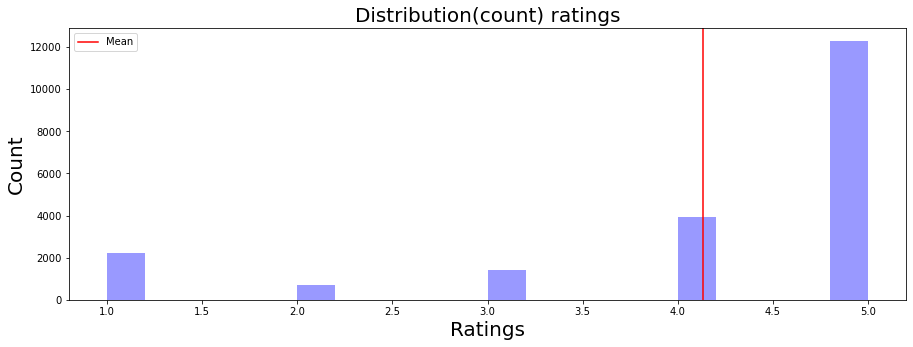

In [45]:
# Distribution count of the restaurent rating !!
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

sns.distplot(y,kde=False,color = 'b',ax =ax,bins=20);
ax.axvline(y.mean(), 0, 1, color='r', label='Mean')
ax.legend();
ax.set_ylabel('Count',size=20)
ax.set_xlabel('Ratings',size=20)
ax.set_title('Distribution(count) ratings',size=20);


In [46]:
from imblearn.over_sampling import SMOTE
sm=SMOTE()
x_over,y_over=sm.fit_resample(x,y)
y_over.value_counts()


5    12297
4    12297
3    12297
2    12297
1    12297
Name: Ratings, dtype: int64

In [47]:
y = pd.get_dummies(y_over, columns = ['Ratings'])
y.head()

,1,2,3,4,5
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,1,0


In [48]:
# Separate the dataframes into X_train, y_train, X_test, and y_test.

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_over,y,test_size=0.3, random_state=3)
print("x_train shape is ", x_train.shape)
print("y_train shape is ", y_train.shape)
print("x_test shape is ", x_test.shape)
print("y_test shape is ", y_test.shape)

x_train shape is  (43039, 5000)
y_train shape is  (43039, 5)
x_test shape is  (18446, 5000)
y_test shape is  (18446, 5)


In [49]:
x_train

<43039x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 2690163 stored elements in Compressed Sparse Row format>

In [50]:
y_train

,1,2,3,4,5
50464,0,0,1,0,0
3058,0,0,0,0,1
12143,0,0,0,0,1
56456,0,0,0,1,0
426,0,0,0,0,1
...,...,...,...,...,...
48056,0,0,1,0,0
59011,0,0,0,1,0
11513,0,0,0,0,1
1688,0,0,0,0,1


In [51]:
x_test

<18446x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 1123569 stored elements in Compressed Sparse Row format>

In [52]:
y_test

,1,2,3,4,5
50358,0,0,1,0,0
29409,1,0,0,0,0
3560,0,0,1,0,0
15477,0,0,0,0,1
39113,0,1,0,0,0
...,...,...,...,...,...
49577,0,0,1,0,0
51682,0,0,1,0,0
21292,1,0,0,0,0
16216,0,0,1,0,0


In [53]:
y_test.value_counts()/y_test.shape[0]

1  2  3  4  5
0  0  0  1  0    0.203892
      1  0  0    0.203133
1  0  0  0  0    0.199393
0  0  0  0  1    0.198038
   1  0  0  0    0.195544
dtype: float64

In [54]:
labels=[1,2,3,4,5]

In [55]:
#Importing the required libraries and evaluation metrics from the scikit learn
from sklearn.metrics import accuracy_score,classification_report,f1_score,auc,roc_curve,roc_auc_score,confusion_matrix,log_loss,precision_score,recall_score,mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier

### Linear Regression

Processing 1
-------------------------------------
ACCURACY SCORE: 0.8220752466659438

F1 score: 0.2683905483727151

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.83      0.99      0.90     14768
           1       0.75      0.16      0.27      3678

    accuracy                           0.82     18446
   macro avg       0.79      0.57      0.58     18446
weighted avg       0.81      0.82      0.77     18446


PRECISION:
 0.745049504950495

RECALL:
 0.16367591082109842

MEAN SQUARED ERROR:
 0.17792475333405616

ROOT MEAN SQ. ERROR:
 0.4218112769166516

LOG_LOSS: 6.145312200215087

AUC_ROC Score:
 0.5748634158655871

TPR: [0.         0.01394908 1.        ] 
FPR: [0.         0.16367591 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



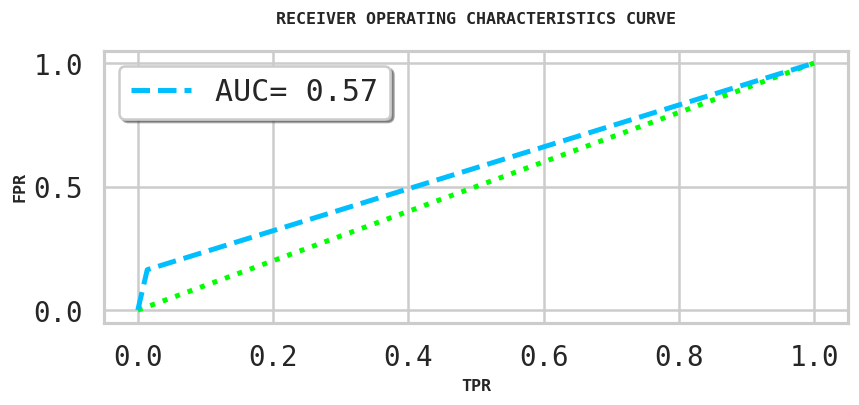





	____________________________________________CONFUSION MATRIX___________________________________________



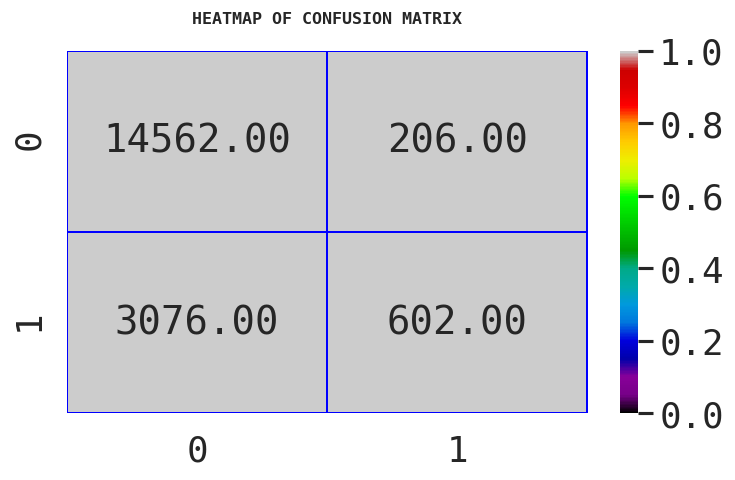



Processing 2
-------------------------------------
ACCURACY SCORE: 0.849615092703025

F1 score: 0.416

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.85      0.99      0.91     14839
           1       0.86      0.27      0.42      3607

    accuracy                           0.85     18446
   macro avg       0.86      0.63      0.66     18446
weighted avg       0.85      0.85      0.82     18446


PRECISION:
 0.8643919510061242

RECALL:
 0.2739118380925977

MEAN SQUARED ERROR:
 0.15038490729697496

ROOT MEAN SQ. ERROR:
 0.3877949294369061

LOG_LOSS: 5.194117405241457

AUC_ROC Score:
 0.6317331951430709

TPR: [0.         0.01044545 1.        ] 
FPR: [0.         0.27391184 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



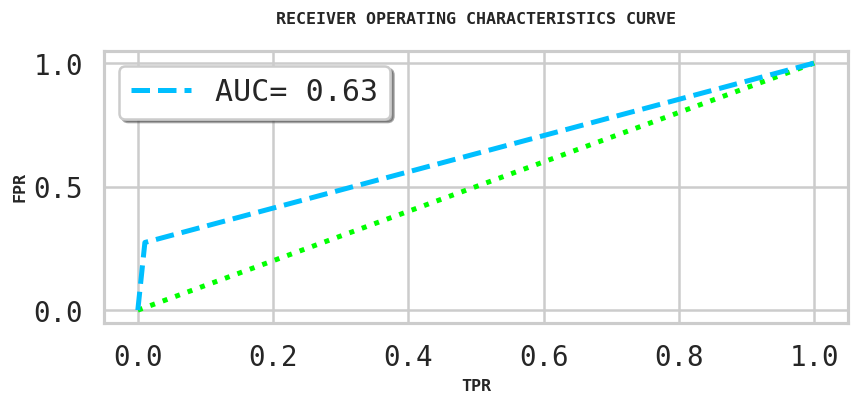





	____________________________________________CONFUSION MATRIX___________________________________________



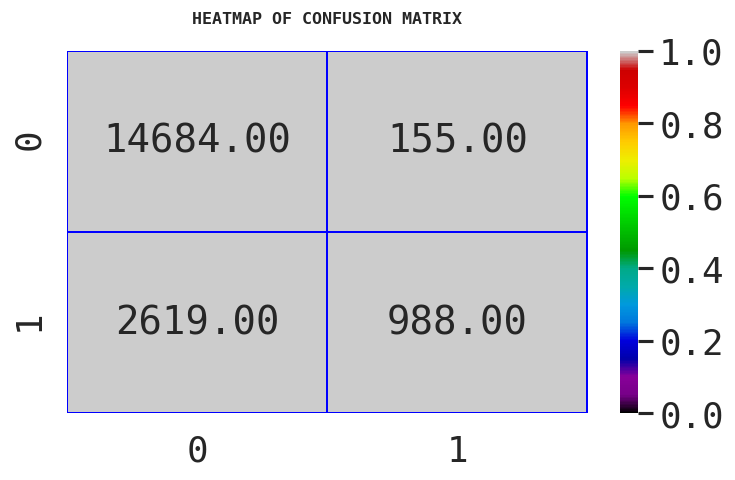



Processing 3
-------------------------------------
ACCURACY SCORE: 0.8225089450287325

F1 score: 0.2753430721558211

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.82      0.99      0.90     14699
           1       0.81      0.17      0.28      3747

    accuracy                           0.82     18446
   macro avg       0.81      0.58      0.59     18446
weighted avg       0.82      0.82      0.77     18446


PRECISION:
 0.8067444876783398

RECALL:
 0.1659994662396584

MEAN SQUARED ERROR:
 0.1774910549712675

ROOT MEAN SQ. ERROR:
 0.4212968727290383

LOG_LOSS: 6.130330318603202

AUC_ROC Score:
 0.5779313611217342

TPR: [0.         0.01013674 1.        ] 
FPR: [0.         0.16599947 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



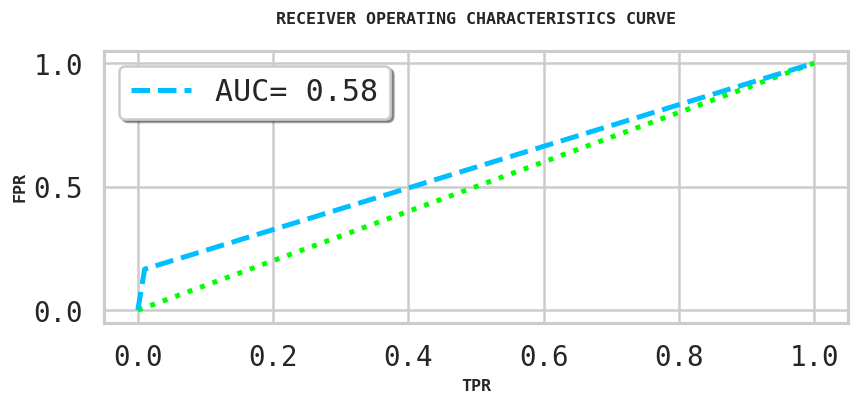





	____________________________________________CONFUSION MATRIX___________________________________________



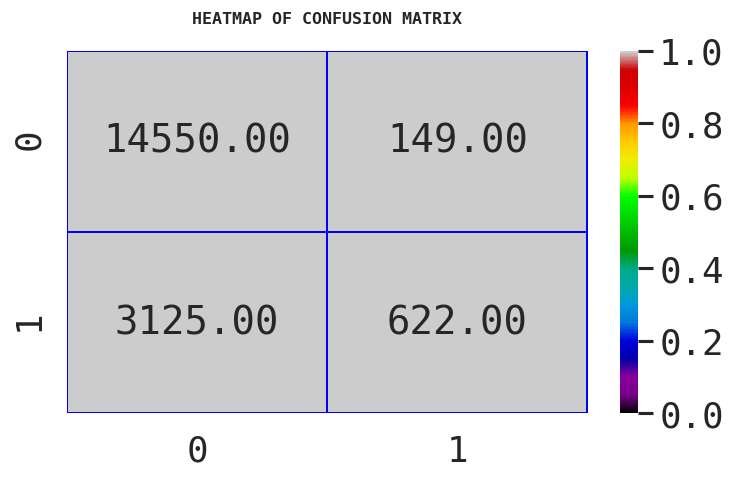



Processing 4
-------------------------------------
ACCURACY SCORE: 0.8090642957822834

F1 score: 0.17863805970149255

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.81      0.99      0.89     14685
           1       0.73      0.10      0.18      3761

    accuracy                           0.81     18446
   macro avg       0.77      0.55      0.54     18446
weighted avg       0.79      0.81      0.75     18446


PRECISION:
 0.7267552182163188

RECALL:
 0.10183461845253922

MEAN SQUARED ERROR:
 0.19093570421771658

ROOT MEAN SQ. ERROR:
 0.4369619024785989

LOG_LOSS: 6.594691835894253

AUC_ROC Score:
 0.5460143470199366

TPR: [0.         0.00980592 1.        ] 
FPR: [0.         0.10183462 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



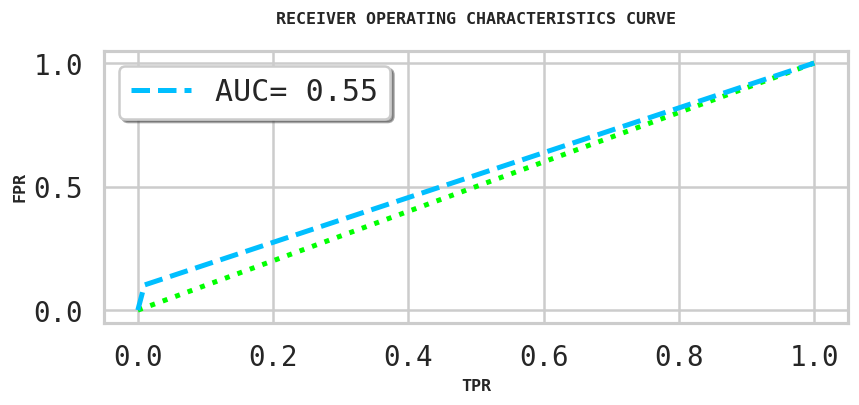





	____________________________________________CONFUSION MATRIX___________________________________________



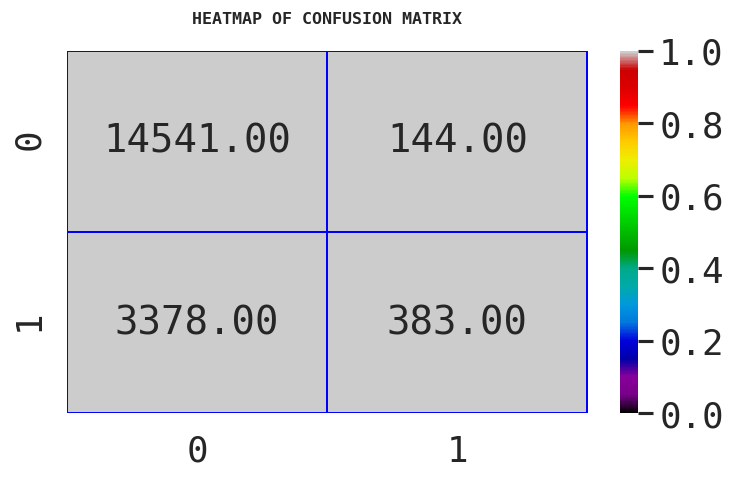



Processing 5
-------------------------------------
ACCURACY SCORE: 0.8242437384798872

F1 score: 0.348995983935743

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.84      0.97      0.90     14793
           1       0.65      0.24      0.35      3653

    accuracy                           0.82     18446
   macro avg       0.75      0.60      0.62     18446
weighted avg       0.80      0.82      0.79     18446


PRECISION:
 0.6548605877920121

RECALL:
 0.2378866684916507

MEAN SQUARED ERROR:
 0.17575626152011276

ROOT MEAN SQ. ERROR:
 0.4192329442208863

LOG_LOSS: 6.0704260700381365

AUC_ROC Score:
 0.6034630395118296

TPR: [0.         0.03096059 1.        ] 
FPR: [0.         0.23788667 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



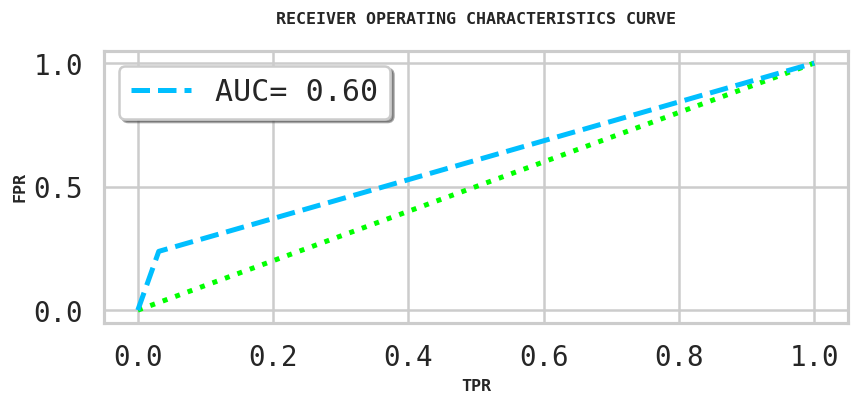





	____________________________________________CONFUSION MATRIX___________________________________________



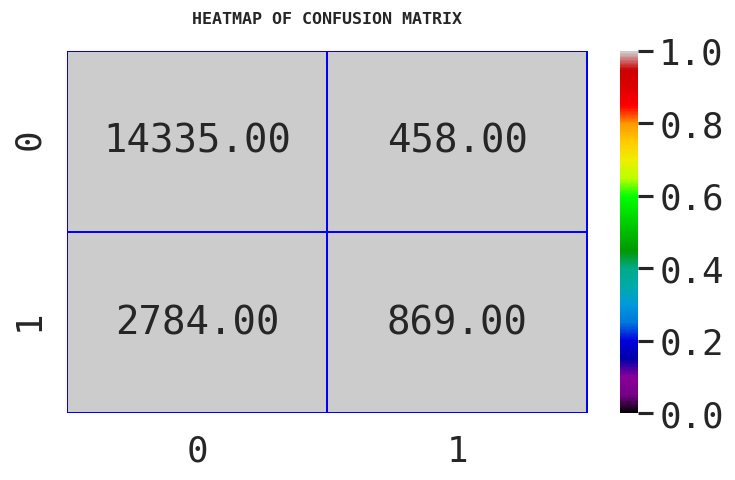

In [55]:
lr = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1))])
F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]

for category in labels:
    print('Processing {}'.format(category))
    print('-------------------------------------')
    lr.fit(x_train, y_train[category])
    pred = lr.predict(x_test)
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
        

    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr)
    
    print('\n')
    #plotting the auc_roc curve
    print('\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')
    print()
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
    #plotting confusion matrix
    print('\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1.3)
    plt.figure(figsize=(7,4),dpi=120)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
    
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)
    


In [56]:
#creating a dataframe to show the performance of the model

logi_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
                               
logi_results.style.set_properties(**{'background-color':'white','color': 'black','border-color': 'black'})

,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,1,0.268391,0.822075,0.745050,0.163676,0.421811,0.177925,0.574863,6.145312
1,2,0.416000,0.849615,0.864392,0.273912,0.387795,0.150385,0.631733,5.194117
2,3,0.275343,0.822509,0.806744,0.165999,0.421297,0.177491,0.577931,6.130330
3,4,0.178638,0.809064,0.726755,0.101835,0.436962,0.190936,0.546014,6.594692
4,5,0.348996,0.824244,0.654861,0.237887,0.419233,0.175756,0.603463,6.070426


### KNeighbors Regressor

Processing 1
-------------------------------------
ACCURACY SCORE: 0.8670172395099208

F1 score: 0.6442349528643946

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.90      0.93      0.92     14768
           1       0.69      0.60      0.64      3678

    accuracy                           0.87     18446
   macro avg       0.80      0.77      0.78     18446
weighted avg       0.86      0.87      0.86     18446


PRECISION:
 0.6903947777432391

RECALL:
 0.6038607939097336

MEAN SQUARED ERROR:
 0.13298276049007915

ROOT MEAN SQ. ERROR:
 0.36466801407592514

LOG_LOSS: 4.593105003564804

AUC_ROC Score:
 0.768208836824856

TPR: [0.         0.06744312 1.        ] 
FPR: [0.         0.60386079 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



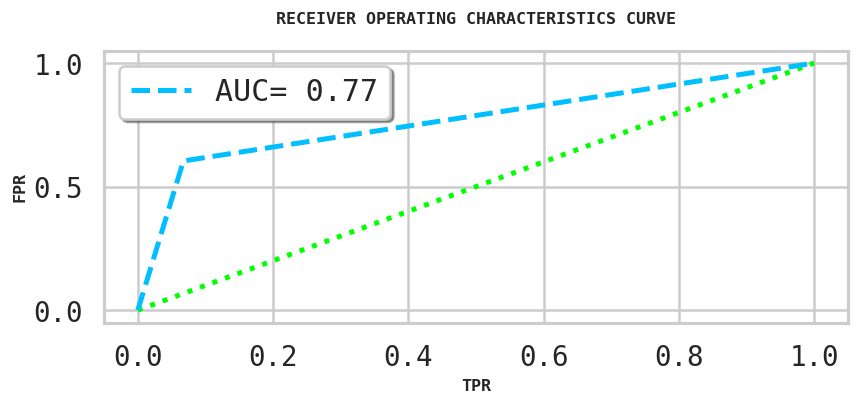





	____________________________________________CONFUSION MATRIX___________________________________________



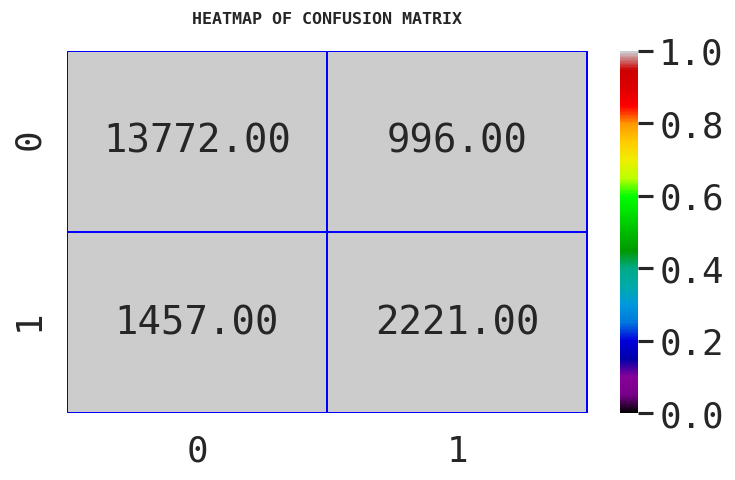



Processing 2
-------------------------------------
ACCURACY SCORE: 0.8898406158516752

F1 score: 0.7433046993431026

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93     14839
           1       0.68      0.82      0.74      3607

    accuracy                           0.89     18446
   macro avg       0.82      0.86      0.84     18446
weighted avg       0.90      0.89      0.89     18446


PRECISION:
 0.6827570201902994

RECALL:
 0.81563626282229

MEAN SQUARED ERROR:
 0.11015938414832484

ROOT MEAN SQ. ERROR:
 0.33190267270440116

LOG_LOSS: 3.804829593632527

AUC_ROC Score:
 0.8617570760839667

TPR: [0.         0.09212211 1.        ] 
FPR: [0.         0.81563626 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



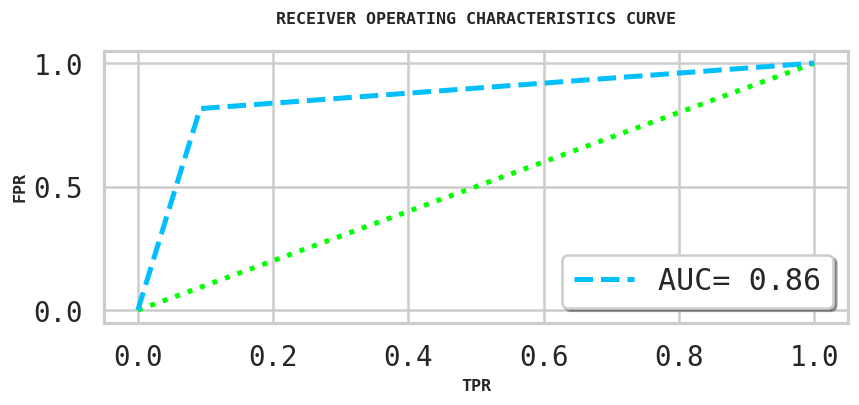





	____________________________________________CONFUSION MATRIX___________________________________________



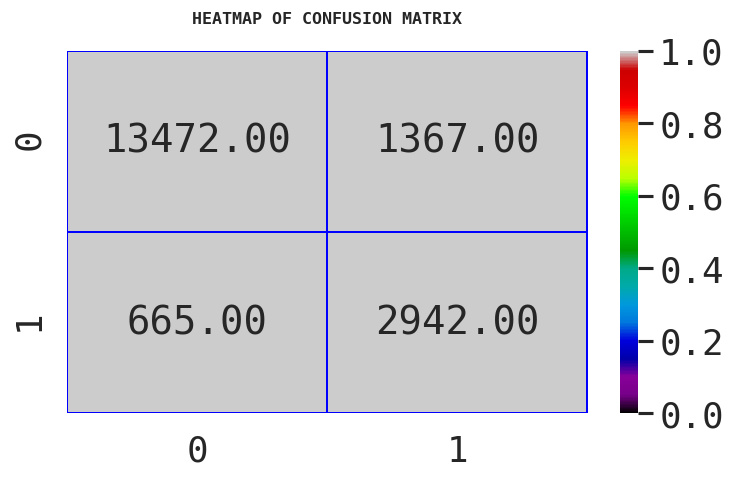



Processing 3
-------------------------------------
ACCURACY SCORE: 0.8732516534750081

F1 score: 0.6893436088227478

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92     14699
           1       0.69      0.69      0.69      3747

    accuracy                           0.87     18446
   macro avg       0.80      0.81      0.80     18446
weighted avg       0.87      0.87      0.87     18446


PRECISION:
 0.6864249801534797

RECALL:
 0.6922871630637843

MEAN SQUARED ERROR:
 0.12674834652499187

ROOT MEAN SQ. ERROR:
 0.3560173402026815

LOG_LOSS: 4.377784166445623

AUC_ROC Score:
 0.8058347169832835

TPR: [0.         0.08061773 1.        ] 
FPR: [0.         0.69228716 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



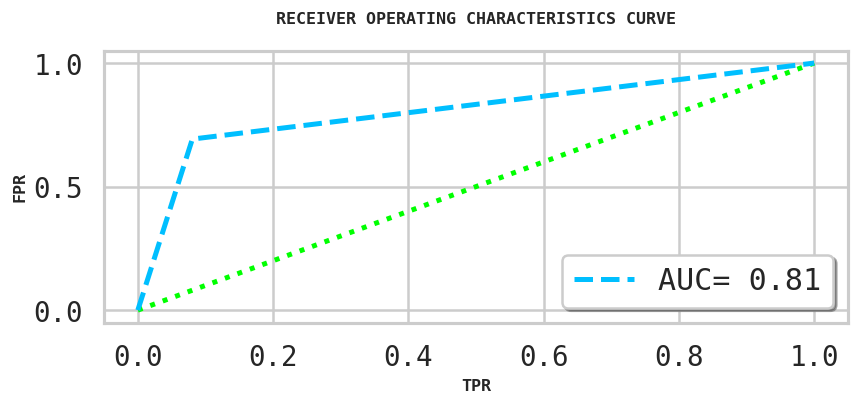





	____________________________________________CONFUSION MATRIX___________________________________________



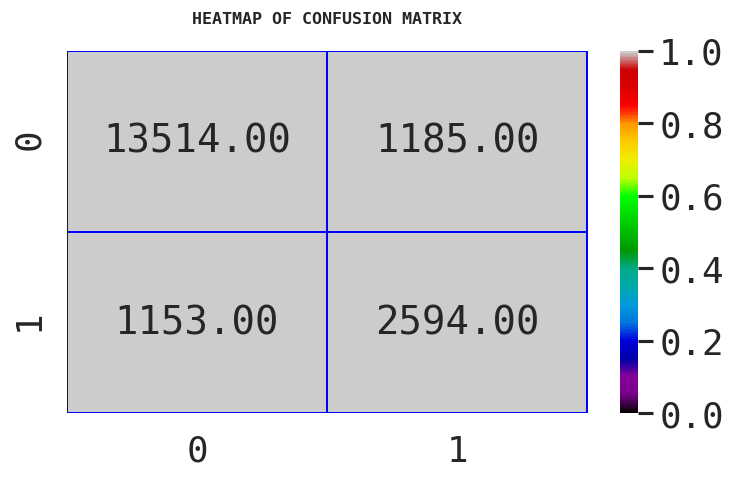



Processing 4
-------------------------------------
ACCURACY SCORE: 0.8440854385774693

F1 score: 0.5235255135851556

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.87      0.95      0.91     14685
           1       0.69      0.42      0.52      3761

    accuracy                           0.84     18446
   macro avg       0.78      0.69      0.72     18446
weighted avg       0.83      0.84      0.83     18446


PRECISION:
 0.6945054945054945

RECALL:
 0.4201010369582558

MEAN SQUARED ERROR:
 0.15591456142253063

ROOT MEAN SQ. ERROR:
 0.3948601795858005

LOG_LOSS: 5.385128300551724

AUC_ROC Score:
 0.6863869161638403

TPR: [0.        0.0473272 1.       ] 
FPR: [0.         0.42010104 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



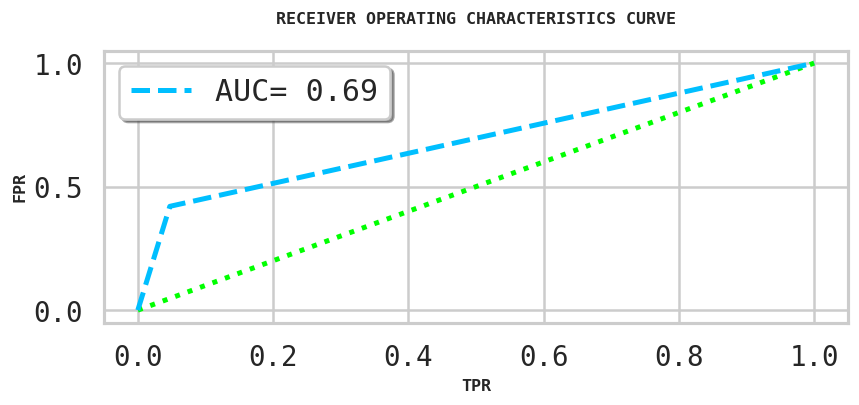





	____________________________________________CONFUSION MATRIX___________________________________________



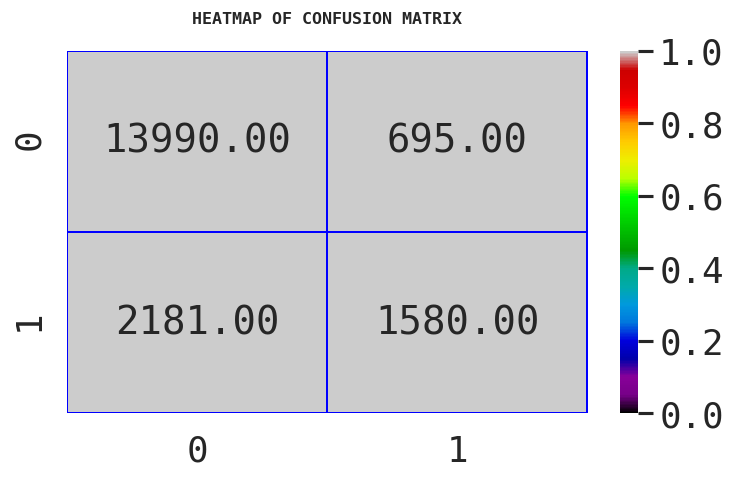



Processing 5
-------------------------------------
ACCURACY SCORE: 0.8098774802125122

F1 score: 0.2546227417640808

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.82      0.97      0.89     14793
           1       0.57      0.16      0.25      3653

    accuracy                           0.81     18446
   macro avg       0.70      0.57      0.57     18446
weighted avg       0.77      0.81      0.77     18446


PRECISION:
 0.5693916349809885

RECALL:
 0.16397481522036683

MEAN SQUARED ERROR:
 0.19012251978748781

ROOT MEAN SQ. ERROR:
 0.4360304115397088

LOG_LOSS: 6.56661883522648

AUC_ROC Score:
 0.5666761117269954

TPR: [0.         0.03062259 1.        ] 
FPR: [0.         0.16397482 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



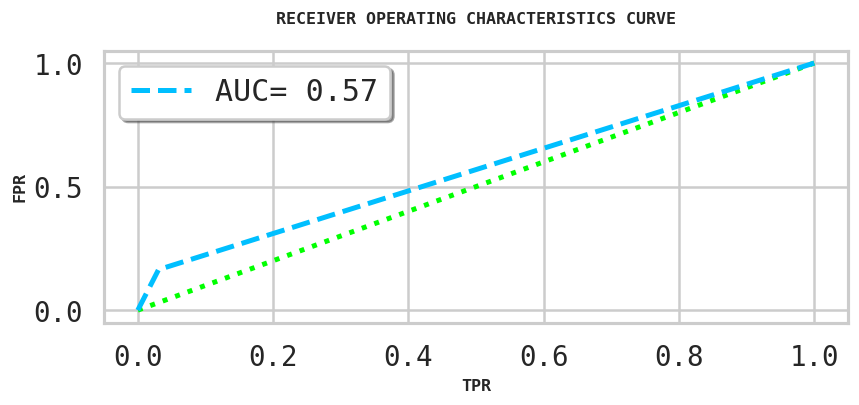





	____________________________________________CONFUSION MATRIX___________________________________________



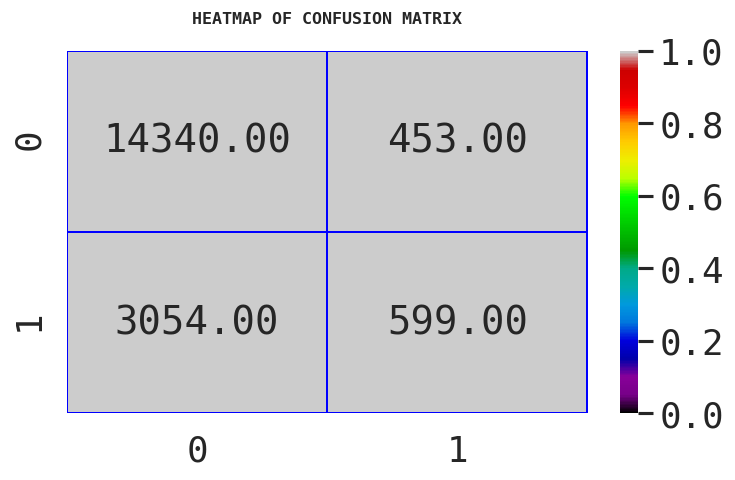

In [57]:
knn_pipeline = Pipeline([('clf', OneVsRestClassifier(KNeighborsClassifier(), n_jobs=1))])
F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]

for category in labels:
    print('Processing {}'.format(category))
    print('-------------------------------------')
    knn_pipeline.fit(x_train, y_train[category])
    pred = knn_pipeline.predict(x_test)
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
        

    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr)
    
    print('\n')
    #plotting the auc_roc curve
    print('\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')
    print()
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
    #plotting confusion matrix
    print('\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1.3)
    plt.figure(figsize=(7,4),dpi=120)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
    
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)
    


In [58]:
#creating a dataframe to show the performance of the model

knn_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
                               
knn_results.style.set_properties(**{'background-color':'white','color': 'black','border-color': 'black'})

,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,1,0.644235,0.867017,0.690395,0.603861,0.364668,0.132983,0.768209,4.593105
1,2,0.743305,0.889841,0.682757,0.815636,0.331903,0.110159,0.861757,3.804830
2,3,0.689344,0.873252,0.686425,0.692287,0.356017,0.126748,0.805835,4.377784
3,4,0.523526,0.844085,0.694505,0.420101,0.394860,0.155915,0.686387,5.385128
4,5,0.254623,0.809877,0.569392,0.163975,0.436030,0.190123,0.566676,6.566619


### Decision Tree Regressor

Processing 1
-------------------------------------
ACCURACY SCORE: 0.8716794969098992

F1 score: 0.6665727567262993

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92     14768
           1       0.69      0.64      0.67      3678

    accuracy                           0.87     18446
   macro avg       0.80      0.79      0.79     18446
weighted avg       0.87      0.87      0.87     18446


PRECISION:
 0.6916106401636948

RECALL:
 0.643284393692224

MEAN SQUARED ERROR:
 0.12832050309010085

ROOT MEAN SQ. ERROR:
 0.3582185130476939

LOG_LOSS: 4.432078895264147

AUC_ROC Score:
 0.7859230744192431

TPR: [0.         0.07143824 1.        ] 
FPR: [0.         0.64328439 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



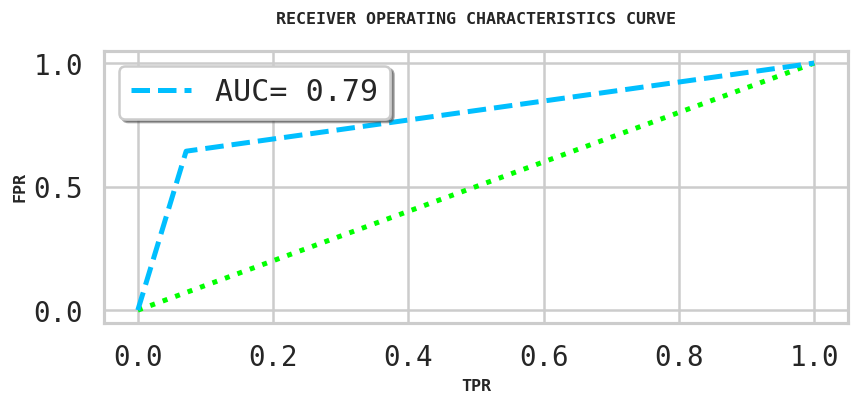





	____________________________________________CONFUSION MATRIX___________________________________________



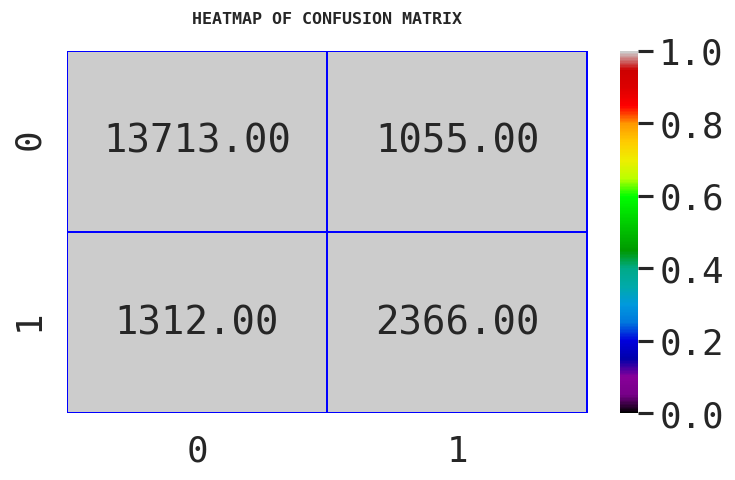



Processing 2
-------------------------------------
ACCURACY SCORE: 0.9231269651957064

F1 score: 0.8016783216783216

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95     14839
           1       0.81      0.79      0.80      3607

    accuracy                           0.92     18446
   macro avg       0.88      0.87      0.88     18446
weighted avg       0.92      0.92      0.92     18446


PRECISION:
 0.8089189952018063

RECALL:
 0.7945661214305517

MEAN SQUARED ERROR:
 0.07687303480429361

ROOT MEAN SQ. ERROR:
 0.2772598687229971

LOG_LOSS: 2.655129906507839

AUC_ROC Score:
 0.8744715505056931

TPR: [0.         0.04562302 1.        ] 
FPR: [0.         0.79456612 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



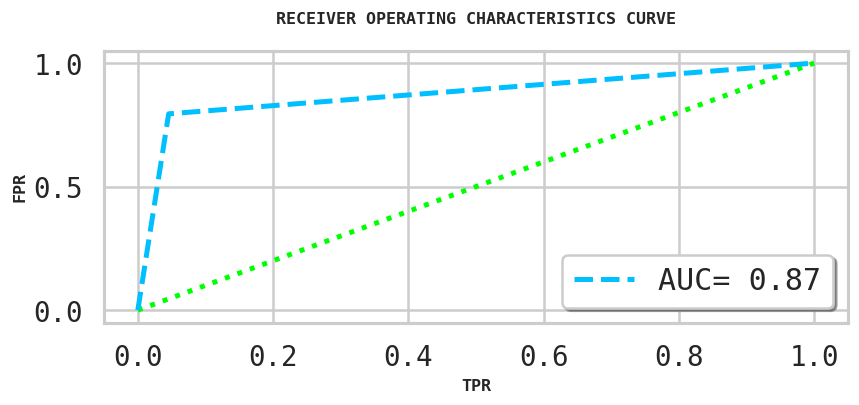





	____________________________________________CONFUSION MATRIX___________________________________________



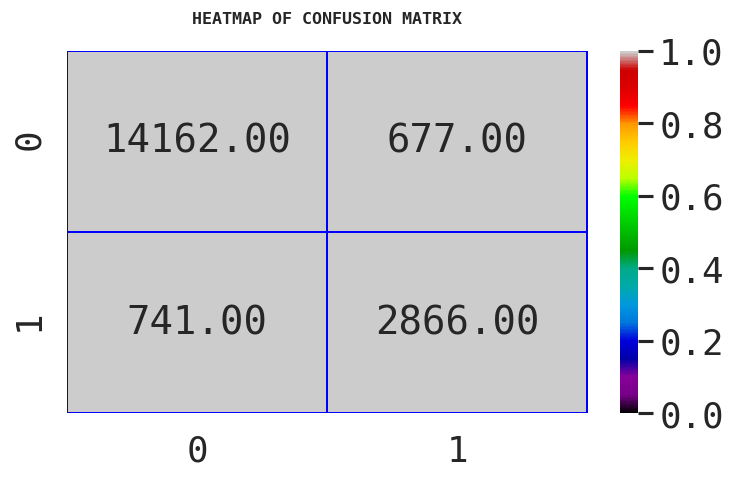



Processing 3
-------------------------------------
ACCURACY SCORE: 0.89233438143771

F1 score: 0.720910623946037

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.92      0.95      0.93     14699
           1       0.76      0.68      0.72      3747

    accuracy                           0.89     18446
   macro avg       0.84      0.81      0.83     18446
weighted avg       0.89      0.89      0.89     18446


PRECISION:
 0.761353517364203

RECALL:
 0.6845476381104884

MEAN SQUARED ERROR:
 0.10766561856228993

ROOT MEAN SQ. ERROR:
 0.328124394951503

LOG_LOSS: 3.718673576744362

AUC_ROC Score:
 0.8149250198172007

TPR: [0.        0.0546976 1.       ] 
FPR: [0.         0.68454764 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



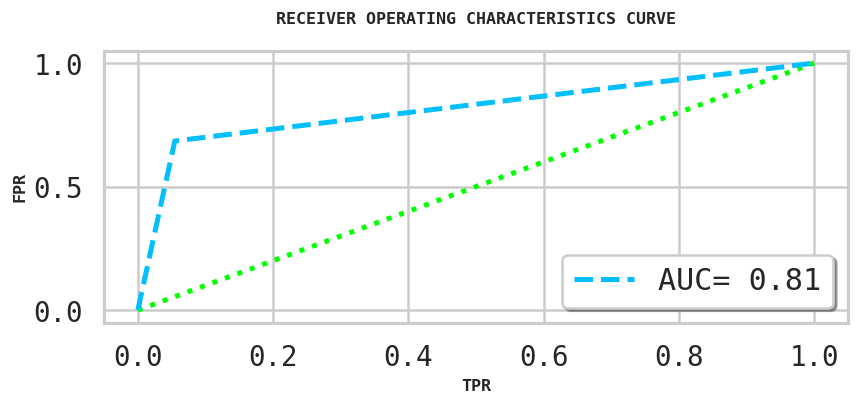





	____________________________________________CONFUSION MATRIX___________________________________________



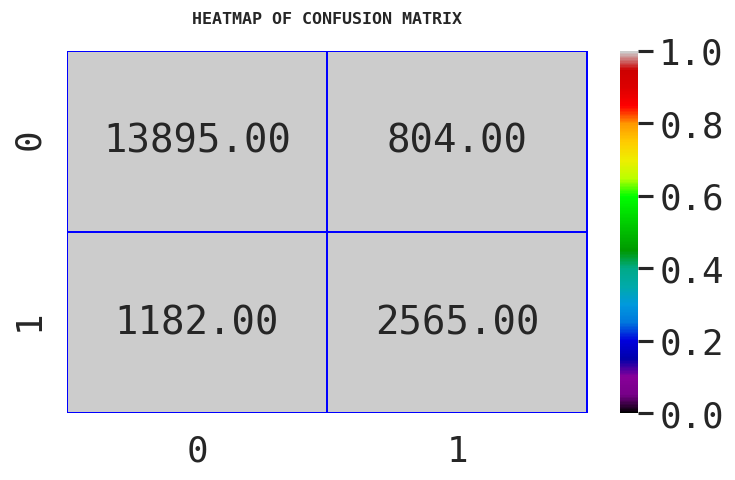



Processing 4
-------------------------------------
ACCURACY SCORE: 0.8438143771007265

F1 score: 0.580090365835884

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90     14685
           1       0.64      0.53      0.58      3761

    accuracy                           0.84     18446
   macro avg       0.76      0.73      0.74     18446
weighted avg       0.84      0.84      0.84     18446


PRECISION:
 0.6419354838709678

RECALL:
 0.5291145971816006

MEAN SQUARED ERROR:
 0.15618562289927357

ROOT MEAN SQ. ERROR:
 0.39520326782463927

LOG_LOSS: 5.394508421711222

AUC_ROC Score:
 0.7267636315836501

TPR: [0.         0.07558733 1.        ] 
FPR: [0.        0.5291146 1.       ]




	____________________________________________ROC_AUC CURVE_______________________________________________



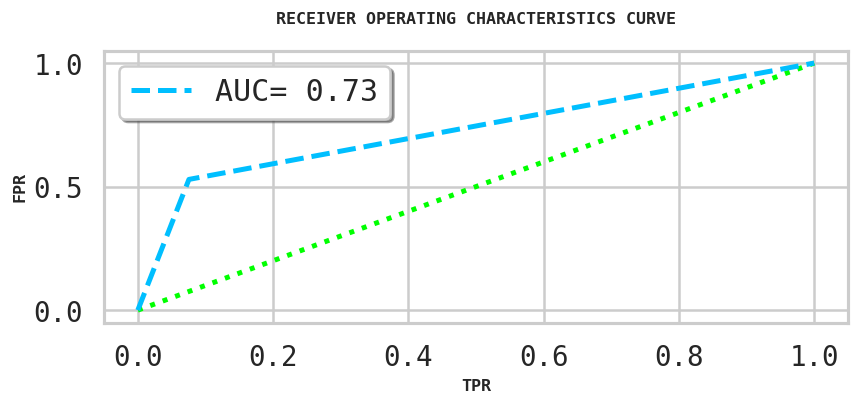





	____________________________________________CONFUSION MATRIX___________________________________________



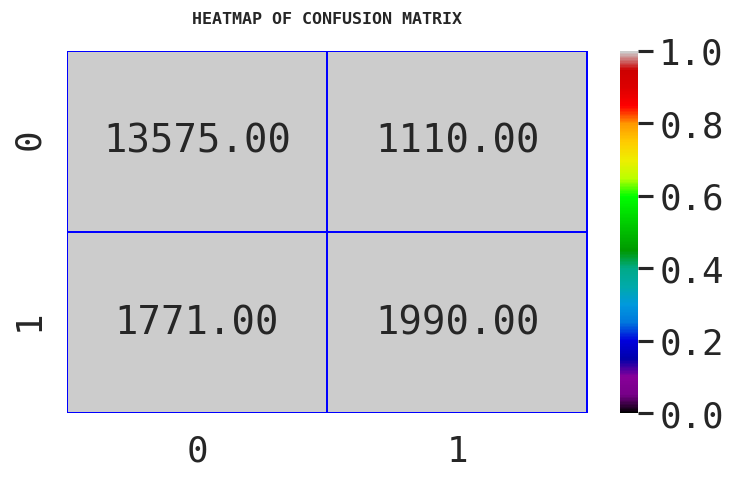



Processing 5
-------------------------------------
ACCURACY SCORE: 0.8420253713542232

F1 score: 0.5462472749922143

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.88      0.93      0.90     14793
           1       0.63      0.48      0.55      3653

    accuracy                           0.84     18446
   macro avg       0.76      0.71      0.73     18446
weighted avg       0.83      0.84      0.83     18446


PRECISION:
 0.6334416756951968

RECALL:
 0.48015329865863676

MEAN SQUARED ERROR:
 0.15797462864577685

ROOT MEAN SQ. ERROR:
 0.3974602227214402

LOG_LOSS: 5.456294373097766

AUC_ROC Score:
 0.705769882615332

TPR: [0.         0.06861353 1.        ] 
FPR: [0.        0.4801533 1.       ]




	____________________________________________ROC_AUC CURVE_______________________________________________



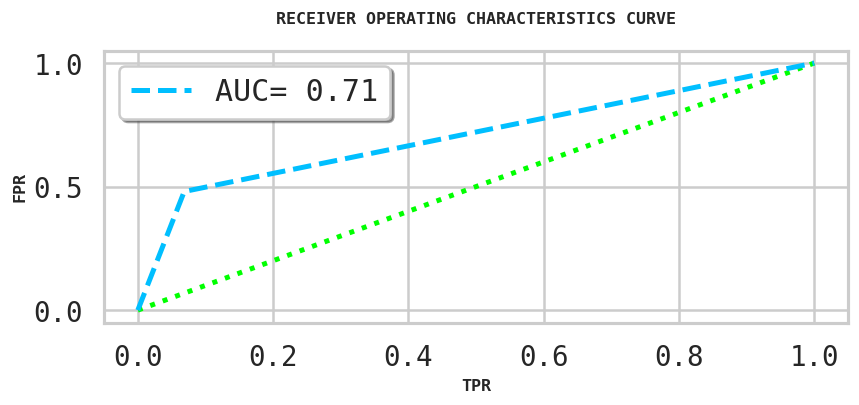





	____________________________________________CONFUSION MATRIX___________________________________________



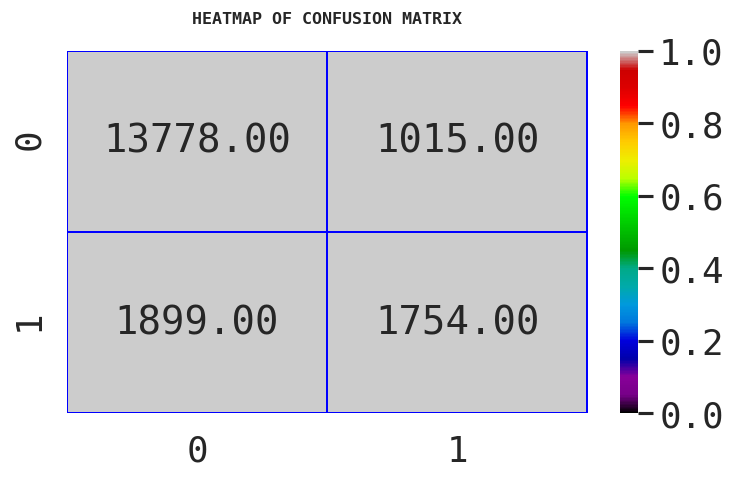

In [59]:
dt_pipeline = Pipeline([('clf', OneVsRestClassifier(DecisionTreeClassifier(), n_jobs=1))])
F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]

for category in labels:
    print('Processing {}'.format(category))
    print('-------------------------------------')
    dt_pipeline.fit(x_train, y_train[category])
    pred = dt_pipeline.predict(x_test)
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
        

    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr)
    
    print('\n')
    #plotting the auc_roc curve
    print('\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')
    print()
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
    #plotting confusion matrix
    print('\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1.3)
    plt.figure(figsize=(7,4),dpi=120)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
    
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)
    


In [60]:
#creating a dataframe to show the performance of the model
#Results for DecisionTree Classifier
dt_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
                               
dt_results.style.set_properties(**{'background-color':'white','color': 'black','border-color': 'black'})

,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,1,0.666573,0.871679,0.691611,0.643284,0.358219,0.128321,0.785923,4.432079
1,2,0.801678,0.923127,0.808919,0.794566,0.277260,0.076873,0.874472,2.655130
2,3,0.720911,0.892334,0.761354,0.684548,0.328124,0.107666,0.814925,3.718674
3,4,0.580090,0.843814,0.641935,0.529115,0.395203,0.156186,0.726764,5.394508
4,5,0.546247,0.842025,0.633442,0.480153,0.397460,0.157975,0.705770,5.456294


### Random Forest Regressor

Processing 1
-------------------------------------
ACCURACY SCORE: 0.912989265965521

F1 score: 0.7543993879112472

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.92      0.97      0.95     14768
           1       0.86      0.67      0.75      3678

    accuracy                           0.91     18446
   macro avg       0.89      0.82      0.85     18446
weighted avg       0.91      0.91      0.91     18446


PRECISION:
 0.8627931396569829

RECALL:
 0.6702011963023382

MEAN SQUARED ERROR:
 0.08701073403447902

ROOT MEAN SQ. ERROR:
 0.2949758194064033

LOG_LOSS: 3.005261279194638

AUC_ROC Score:
 0.8218286588228918

TPR: [0.         0.02654388 1.        ] 
FPR: [0.        0.6702012 1.       ]




	____________________________________________ROC_AUC CURVE_______________________________________________



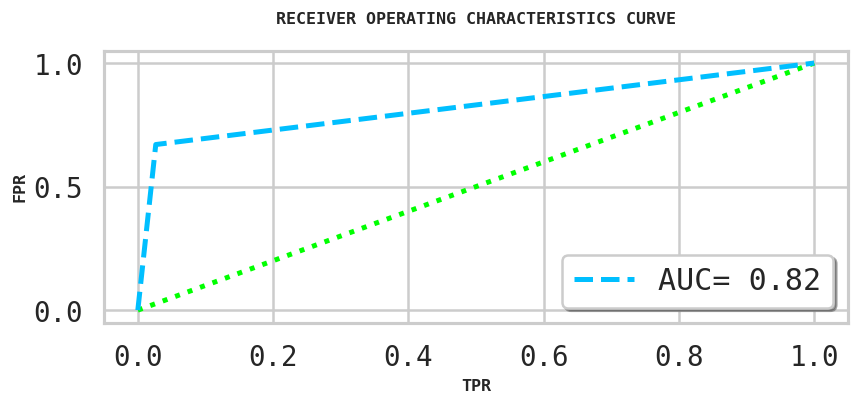





	____________________________________________CONFUSION MATRIX___________________________________________



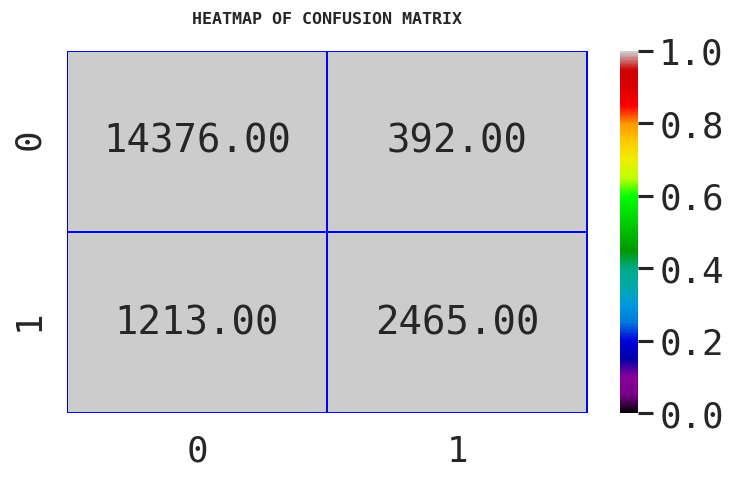



Processing 2
-------------------------------------
ACCURACY SCORE: 0.9557627669955546

F1 score: 0.8808411214953271

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     14839
           1       0.93      0.84      0.88      3607

    accuracy                           0.96     18446
   macro avg       0.95      0.91      0.93     18446
weighted avg       0.96      0.96      0.95     18446


PRECISION:
 0.9305769824128356

RECALL:
 0.8361519268089825

MEAN SQUARED ERROR:
 0.04423723300444541

ROOT MEAN SQ. ERROR:
 0.21032649144709614

LOG_LOSS: 1.527909652372814

AUC_ROC Score:
 0.9104945899965797

TPR: [0.         0.01516275 1.        ] 
FPR: [0.         0.83615193 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



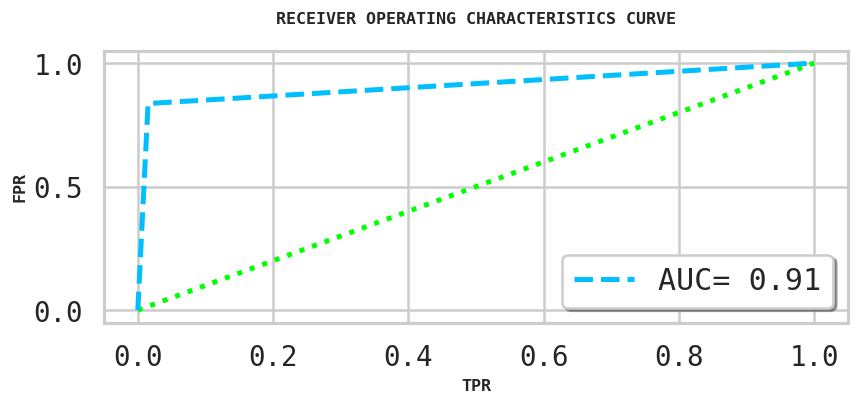





	____________________________________________CONFUSION MATRIX___________________________________________



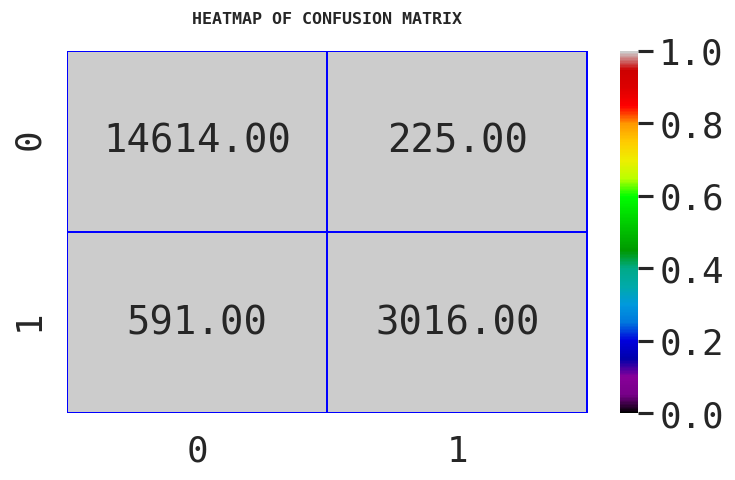



Processing 3
-------------------------------------
ACCURACY SCORE: 0.9183020709096823

F1 score: 0.774569932685116

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95     14699
           1       0.88      0.69      0.77      3747

    accuracy                           0.92     18446
   macro avg       0.90      0.83      0.86     18446
weighted avg       0.92      0.92      0.91     18446


PRECISION:
 0.8812117086453369

RECALL:
 0.6909527622097679

MEAN SQUARED ERROR:
 0.08169792909031769

ROOT MEAN SQ. ERROR:
 0.2858284959382421

LOG_LOSS: 2.821761633233956

AUC_ROC Score:
 0.8336048252167284

TPR: [0.         0.02374311 1.        ] 
FPR: [0.         0.69095276 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



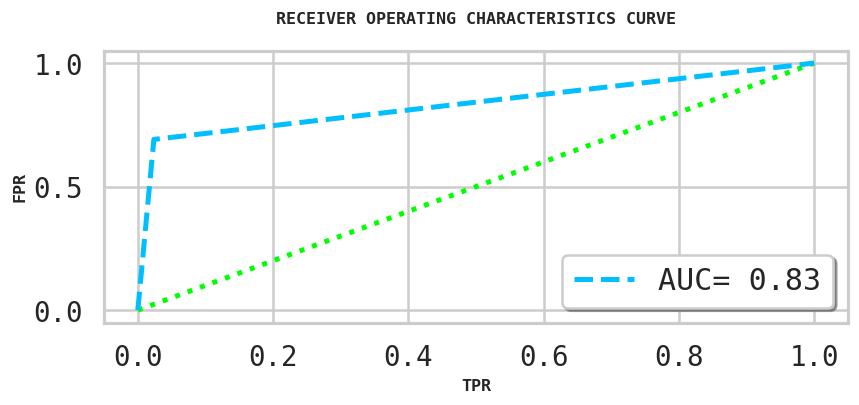





	____________________________________________CONFUSION MATRIX___________________________________________



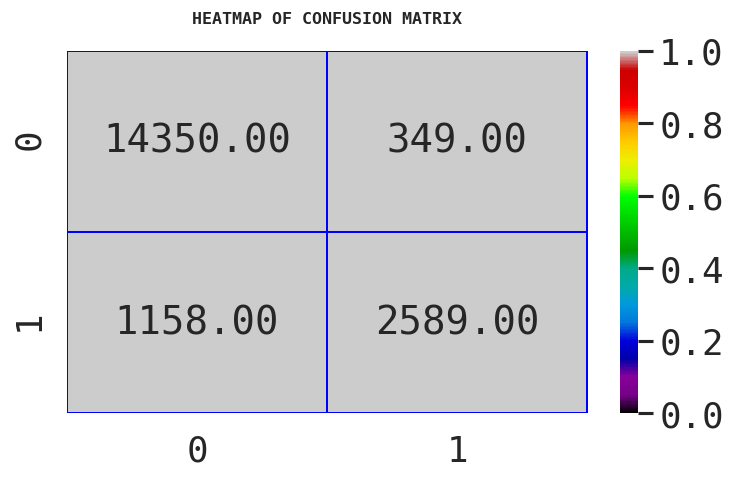



Processing 4
-------------------------------------
ACCURACY SCORE: 0.8704868264122303

F1 score: 0.6107218510672967

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92     14685
           1       0.79      0.50      0.61      3761

    accuracy                           0.87     18446
   macro avg       0.84      0.73      0.77     18446
weighted avg       0.86      0.87      0.86     18446


PRECISION:
 0.7887205387205387

RECALL:
 0.4982717362403616

MEAN SQUARED ERROR:
 0.1295131735877697

ROOT MEAN SQ. ERROR:
 0.35987938755612237

LOG_LOSS: 4.473248303445277

AUC_ROC Score:
 0.7320435970953255

TPR: [0.         0.03418454 1.        ] 
FPR: [0.         0.49827174 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



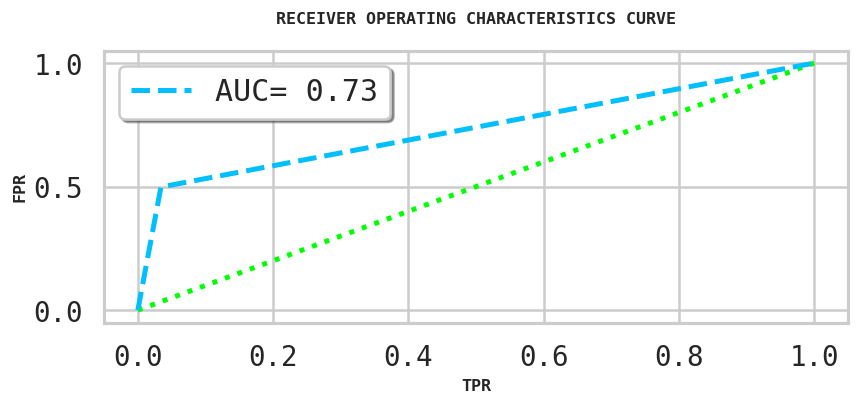





	____________________________________________CONFUSION MATRIX___________________________________________



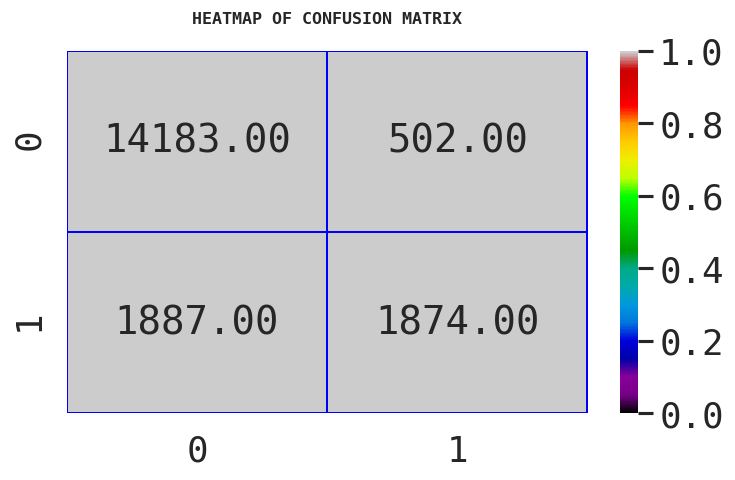



Processing 5
-------------------------------------
ACCURACY SCORE: 0.8470129025262929

F1 score: 0.4922634041021951

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.86      0.96      0.91     14793
           1       0.72      0.37      0.49      3653

    accuracy                           0.85     18446
   macro avg       0.79      0.67      0.70     18446
weighted avg       0.83      0.85      0.83     18446


PRECISION:
 0.7181102362204724

RECALL:
 0.37448672324117166

MEAN SQUARED ERROR:
 0.15298709747370703

ROOT MEAN SQ. ERROR:
 0.3911356509878728

LOG_LOSS: 5.284010428833241

AUC_ROC Score:
 0.6690928850438266

TPR: [0.         0.03630095 1.        ] 
FPR: [0.         0.37448672 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



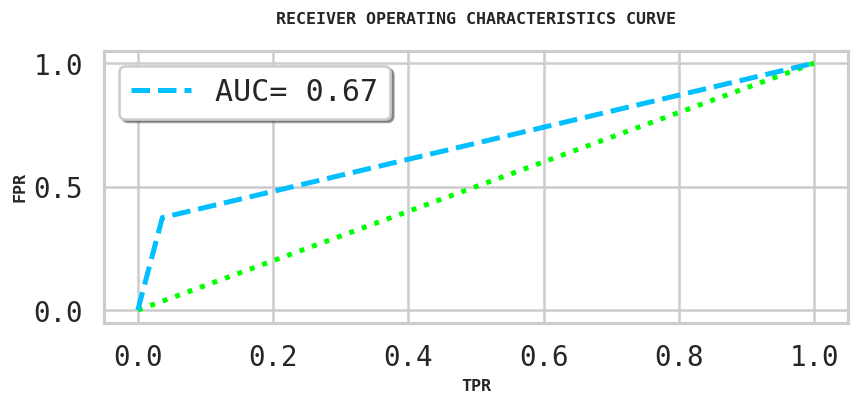





	____________________________________________CONFUSION MATRIX___________________________________________



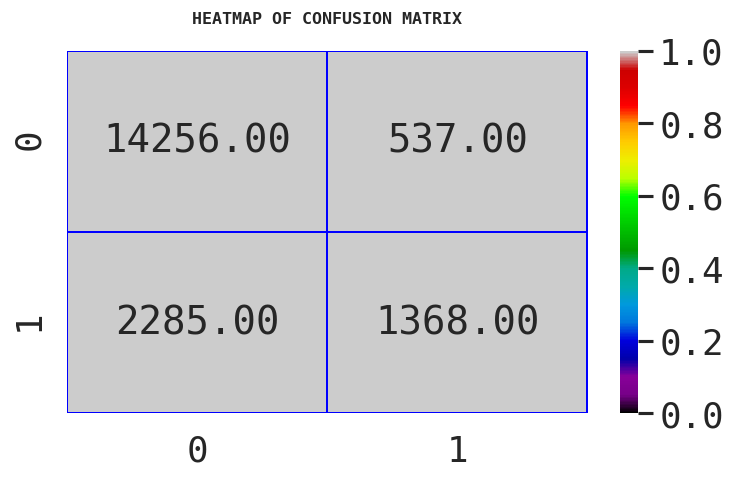

In [62]:
Rf_pipeline = Pipeline([('clf', OneVsRestClassifier(RandomForestClassifier(), n_jobs=1))])
F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]

for category in labels:
    print('Processing {}'.format(category))
    print('-------------------------------------')
    Rf_pipeline.fit(x_train, y_train[category])
    pred = Rf_pipeline.predict(x_test)
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
        

    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr)
    
    print('\n')
    #plotting the auc_roc curve
    print('\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')
    print()
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
    #plotting confusion matrix
    print('\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1.3)
    plt.figure(figsize=(7,4),dpi=120)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
    
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)
    


In [63]:
#creating a dataframe to show the performance of the model

Rf_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
                               
Rf_results.style.set_properties(**{'background-color':'white','color': 'black','border-color': 'black'})

,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,1,0.754399,0.912989,0.862793,0.670201,0.294976,0.087011,0.821829,3.005261
1,2,0.880841,0.955763,0.930577,0.836152,0.210326,0.044237,0.910495,1.527910
2,3,0.774570,0.918302,0.881212,0.690953,0.285828,0.081698,0.833605,2.821762
3,4,0.610722,0.870487,0.788721,0.498272,0.359879,0.129513,0.732044,4.473248
4,5,0.492263,0.847013,0.718110,0.374487,0.391136,0.152987,0.669093,5.284010


### Linear Support Vector Regressor

Processing 1
-------------------------------------
ACCURACY SCORE: 0.8493982435216307

F1 score: 0.49981994958588405

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.86      0.97      0.91     14768
           1       0.74      0.38      0.50      3678

    accuracy                           0.85     18446
   macro avg       0.80      0.67      0.71     18446
weighted avg       0.84      0.85      0.83     18446


PRECISION:
 0.7398720682302772

RECALL:
 0.377379010331702

MEAN SQUARED ERROR:
 0.1506017564783693

ROOT MEAN SQ. ERROR:
 0.3880744213142233

LOG_LOSS: 5.201621545517067

AUC_ROC Score:
 0.6721672949816689

TPR: [0.         0.03304442 1.        ] 
FPR: [0.         0.37737901 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



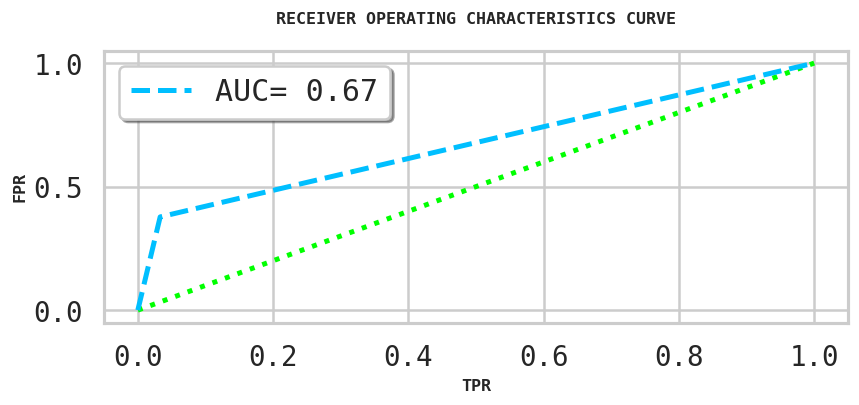





	____________________________________________CONFUSION MATRIX___________________________________________



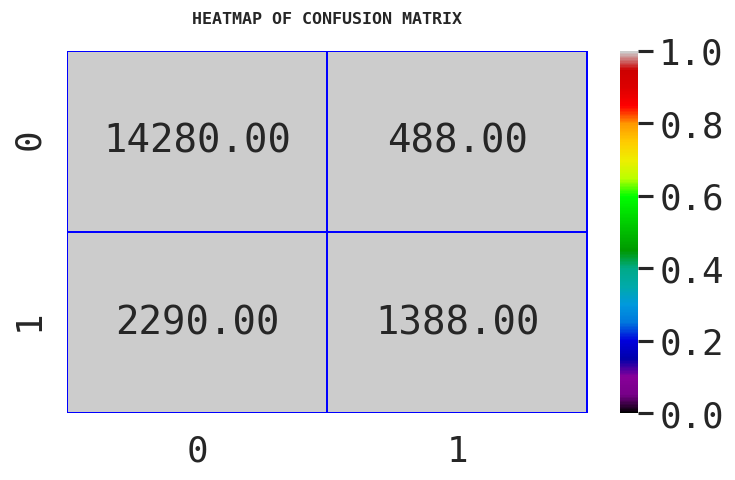



Processing 2
-------------------------------------
ACCURACY SCORE: 0.9004662257399978

F1 score: 0.6974291364535267

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94     14839
           1       0.86      0.59      0.70      3607

    accuracy                           0.90     18446
   macro avg       0.88      0.78      0.82     18446
weighted avg       0.90      0.90      0.89     18446


PRECISION:
 0.8598130841121495

RECALL:
 0.5866370945383975

MEAN SQUARED ERROR:
 0.09953377426000216

ROOT MEAN SQ. ERROR:
 0.3154897371706442

LOG_LOSS: 3.4377897279718876

AUC_ROC Score:
 0.781693774710401

TPR: [0.         0.02324955 1.        ] 
FPR: [0.         0.58663709 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



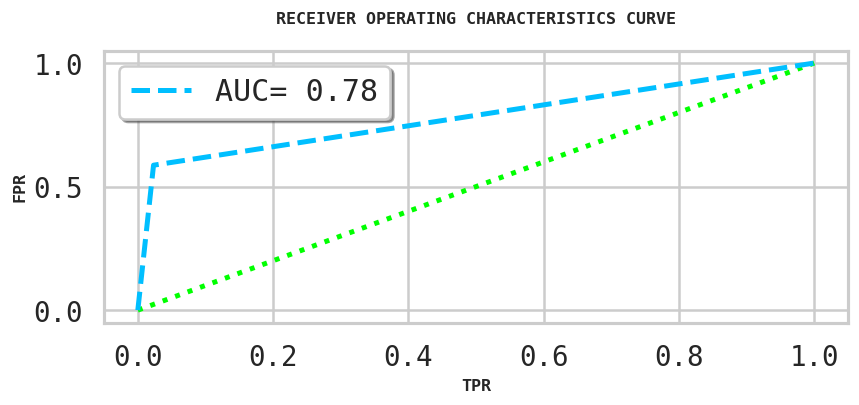





	____________________________________________CONFUSION MATRIX___________________________________________



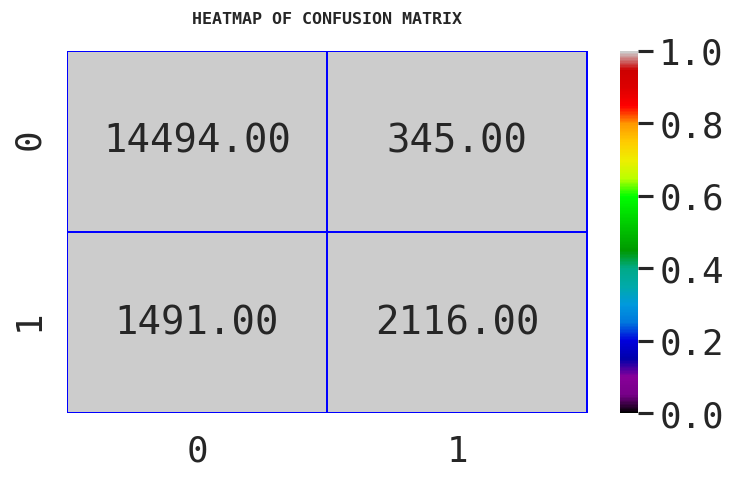



Processing 3
-------------------------------------
ACCURACY SCORE: 0.8598612165239076

F1 score: 0.5528455284552845

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.87      0.97      0.92     14699
           1       0.79      0.43      0.55      3747

    accuracy                           0.86     18446
   macro avg       0.83      0.70      0.73     18446
weighted avg       0.85      0.86      0.84     18446


PRECISION:
 0.7856440511307768

RECALL:
 0.42647451294368827

MEAN SQUARED ERROR:
 0.14013878347609238

ROOT MEAN SQ. ERROR:
 0.3743511499596233

LOG_LOSS: 4.840241006468811

AUC_ROC Score:
 0.6984063155915121

TPR: [0.         0.02966188 1.        ] 
FPR: [0.         0.42647451 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



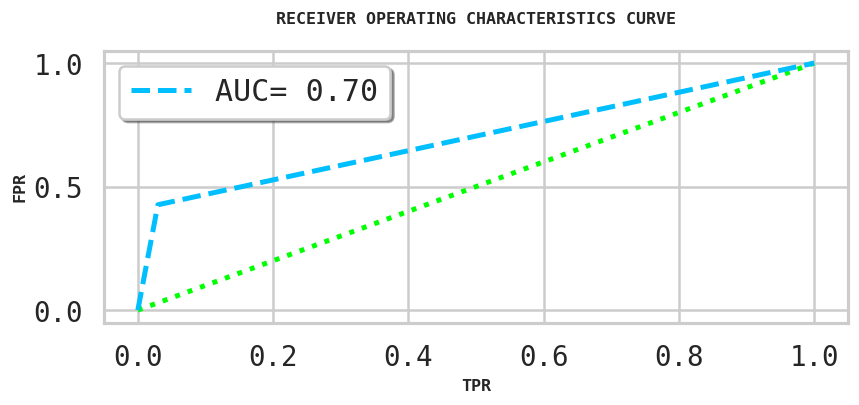





	____________________________________________CONFUSION MATRIX___________________________________________



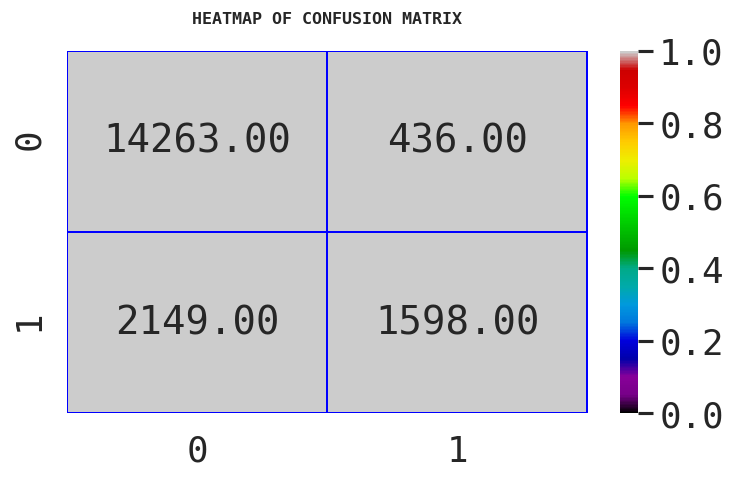



Processing 4
-------------------------------------
ACCURACY SCORE: 0.8160576818822509

F1 score: 0.35823718554946093

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.83      0.96      0.89     14685
           1       0.62      0.25      0.36      3761

    accuracy                           0.82     18446
   macro avg       0.73      0.61      0.63     18446
weighted avg       0.79      0.82      0.78     18446


PRECISION:
 0.6205766710353866

RECALL:
 0.2517947354427014

MEAN SQUARED ERROR:
 0.1839423181177491

ROOT MEAN SQ. ERROR:
 0.42888497072962245

LOG_LOSS: 6.353167693529439

AUC_ROC Score:
 0.6061833738500535

TPR: [0.         0.03942799 1.        ] 
FPR: [0.         0.25179474 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



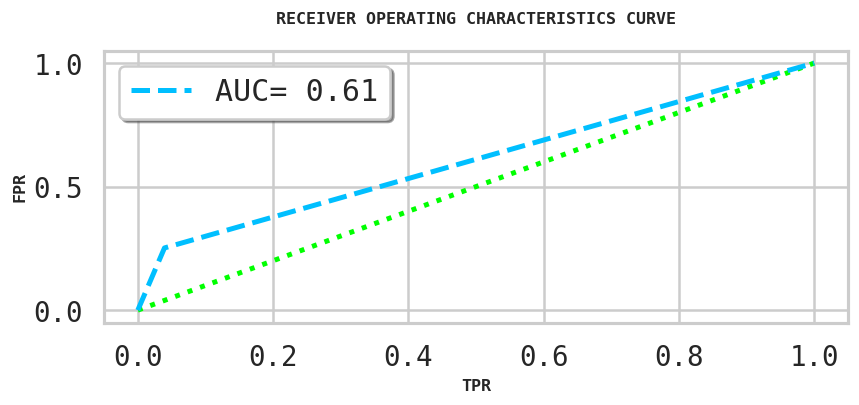





	____________________________________________CONFUSION MATRIX___________________________________________



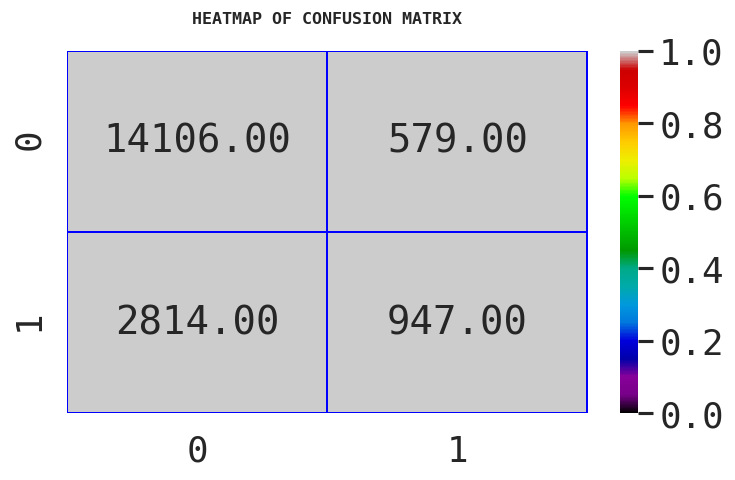



Processing 5
-------------------------------------
ACCURACY SCORE: 0.8399653041309769

F1 score: 0.4705882352941177

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.86      0.96      0.91     14793
           1       0.68      0.36      0.47      3653

    accuracy                           0.84     18446
   macro avg       0.77      0.66      0.69     18446
weighted avg       0.82      0.84      0.82     18446


PRECISION:
 0.6822672906916276

RECALL:
 0.359156857377498

MEAN SQUARED ERROR:
 0.1600346958690231

ROOT MEAN SQ. ERROR:
 0.4000433674853554

LOG_LOSS: 5.527429061683085

AUC_ROC Score:
 0.658926769120034

TPR: [0.         0.04130332 1.        ] 
FPR: [0.         0.35915686 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



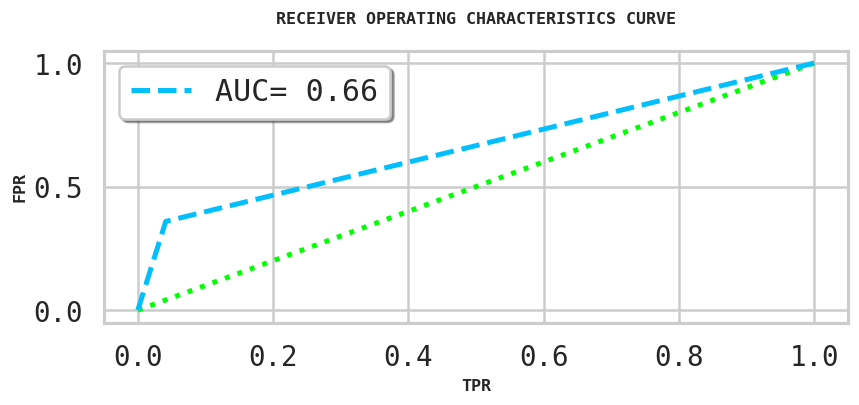





	____________________________________________CONFUSION MATRIX___________________________________________



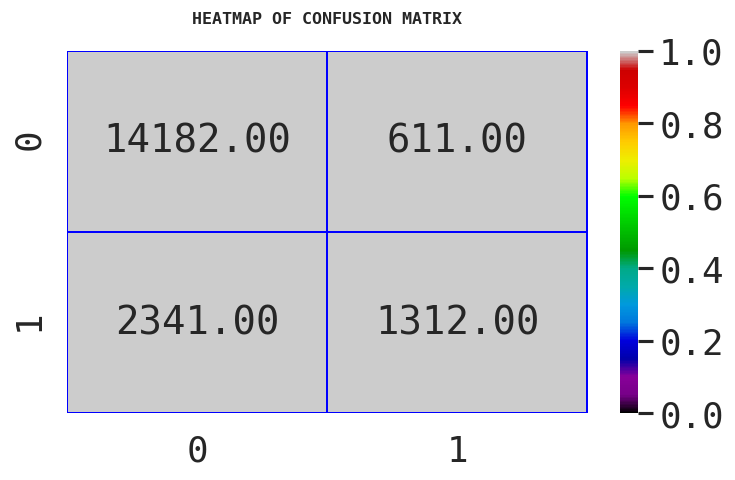

In [63]:
lvsc_pipeline = Pipeline([('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1))])
F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]

for category in labels:
    print('Processing {}'.format(category))
    print('-------------------------------------')
    lvsc_pipeline.fit(x_train, y_train[category])
    pred = lvsc_pipeline.predict(x_test)
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
        

    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr)
    
    print('\n')
    #plotting the auc_roc curve
    print('\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')
    print()
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
    #plotting confusion matrix
    print('\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1.3)
    plt.figure(figsize=(7,4),dpi=120)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
    
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)
    


In [64]:
#creating a dataframe to show the performance of the model

lsvc_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
                               
lsvc_results.style.set_properties(**{'background-color':'white','color': 'black','border-color': 'black'})

,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,1,0.499820,0.849398,0.739872,0.377379,0.388074,0.150602,0.672167,5.201622
1,2,0.697429,0.900466,0.859813,0.586637,0.315490,0.099534,0.781694,3.437790
2,3,0.552846,0.859861,0.785644,0.426475,0.374351,0.140139,0.698406,4.840241
3,4,0.358237,0.816058,0.620577,0.251795,0.428885,0.183942,0.606183,6.353168
4,5,0.470588,0.839965,0.682267,0.359157,0.400043,0.160035,0.658927,5.527429


### Multi Nominal Naive Bayes

Processing 1
-------------------------------------
ACCURACY SCORE: 0.8032635801799848

F1 score: 0.2371242379651041

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.82      0.97      0.89     14768
           1       0.52      0.15      0.24      3678

    accuracy                           0.80     18446
   macro avg       0.67      0.56      0.56     18446
weighted avg       0.76      0.80      0.76     18446


PRECISION:
 0.5227062094531975

RECALL:
 0.1533442088091354

MEAN SQUARED ERROR:
 0.1967364198200152

ROOT MEAN SQ. ERROR:
 0.44354979407053635

LOG_LOSS: 6.795057537124982

AUC_ROC Score:
 0.5592357555421625

TPR: [0.        0.0348727 1.       ] 
FPR: [0.         0.15334421 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



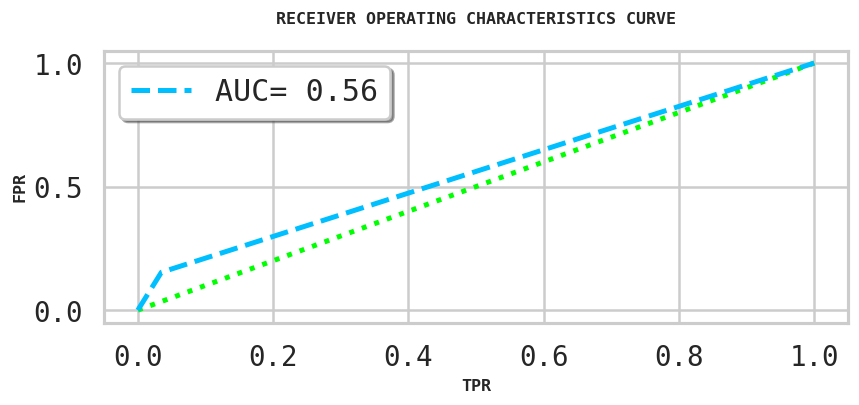





	____________________________________________CONFUSION MATRIX___________________________________________



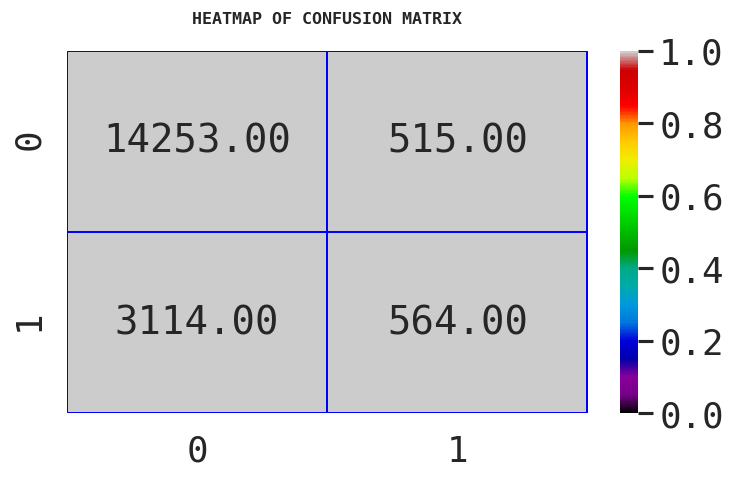



Processing 2
-------------------------------------
ACCURACY SCORE: 0.8180093245147999

F1 score: 0.2511710907874191

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.83      0.98      0.90     14839
           1       0.64      0.16      0.25      3607

    accuracy                           0.82     18446
   macro avg       0.73      0.57      0.57     18446
weighted avg       0.79      0.82      0.77     18446


PRECISION:
 0.6426940639269406

RECALL:
 0.15608538952037704

MEAN SQUARED ERROR:
 0.18199067548520004

ROOT MEAN SQ. ERROR:
 0.42660365151414265

LOG_LOSS: 6.285748814469849

AUC_ROC Score:
 0.5674961619749604

TPR: [0.         0.02109307 1.        ] 
FPR: [0.         0.15608539 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



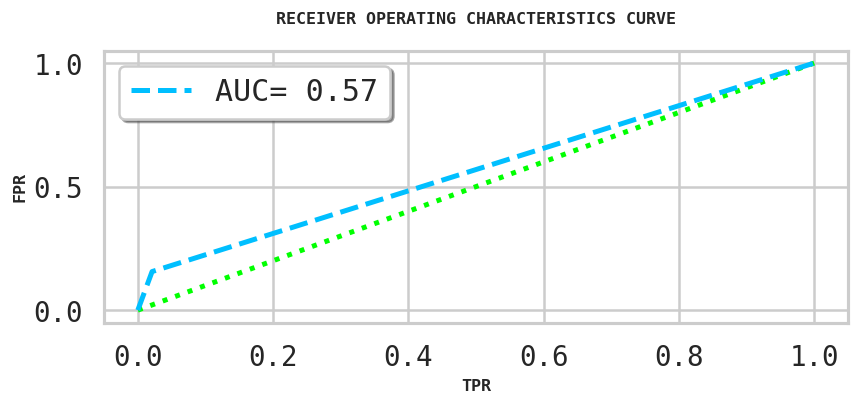





	____________________________________________CONFUSION MATRIX___________________________________________



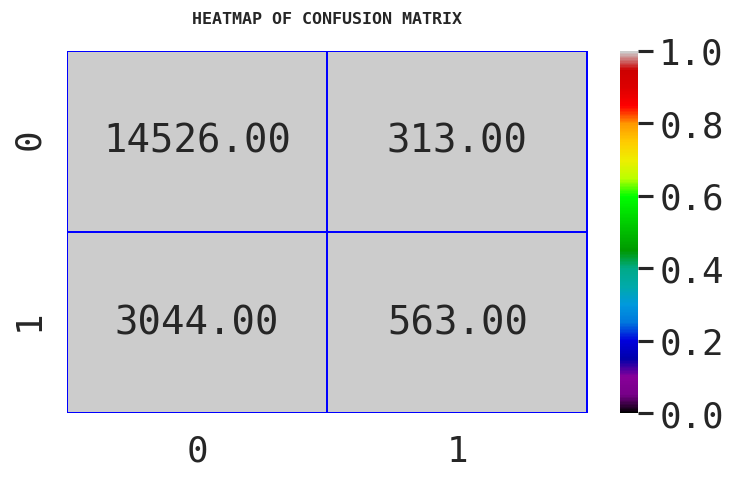



Processing 3
-------------------------------------
ACCURACY SCORE: 0.8107448769380896

F1 score: 0.14832886069773116

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.81      1.00      0.89     14699
           1       0.86      0.08      0.15      3747

    accuracy                           0.81     18446
   macro avg       0.84      0.54      0.52     18446
weighted avg       0.82      0.81      0.74     18446


PRECISION:
 0.8636363636363636

RECALL:
 0.08113157192420603

MEAN SQUARED ERROR:
 0.18925512306191045

ROOT MEAN SQ. ERROR:
 0.4350346228312299

LOG_LOSS: 6.536642457731207

AUC_ROC Score:
 0.5389330218284885

TPR: [0.         0.00326553 1.        ] 
FPR: [0.         0.08113157 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



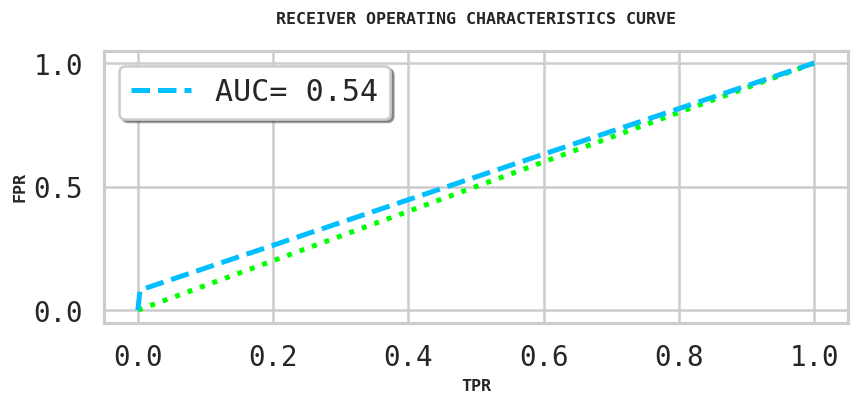





	____________________________________________CONFUSION MATRIX___________________________________________



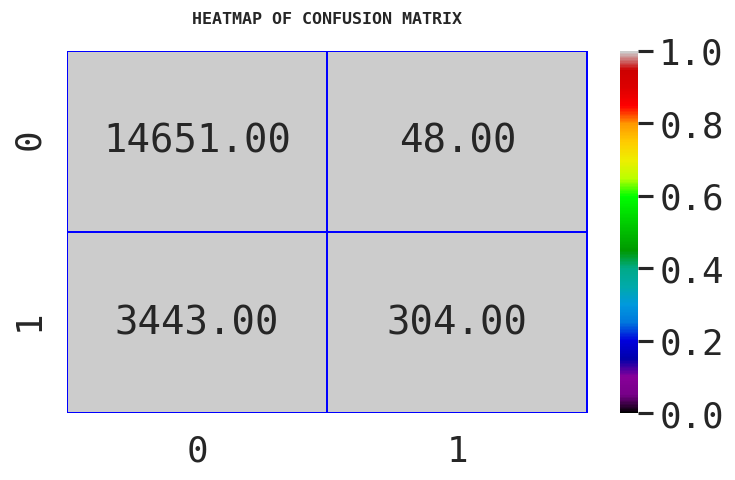



Processing 4
-------------------------------------
ACCURACY SCORE: 0.8034804293613792

F1 score: 0.10427477143563132

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.80      0.99      0.89     14685
           1       0.74      0.06      0.10      3761

    accuracy                           0.80     18446
   macro avg       0.77      0.53      0.50     18446
weighted avg       0.79      0.80      0.73     18446


PRECISION:
 0.7377622377622378

RECALL:
 0.05610210050518479

MEAN SQUARED ERROR:
 0.19651957063862083

ROOT MEAN SQ. ERROR:
 0.44330527928124297

LOG_LOSS: 6.787548758612083

AUC_ROC Score:
 0.5254974241034606

TPR: [0.         0.00510725 1.        ] 
FPR: [0.        0.0561021 1.       ]




	____________________________________________ROC_AUC CURVE_______________________________________________



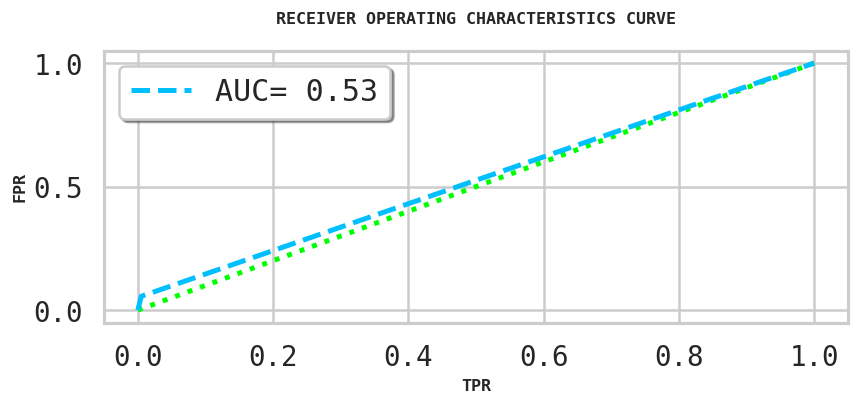





	____________________________________________CONFUSION MATRIX___________________________________________



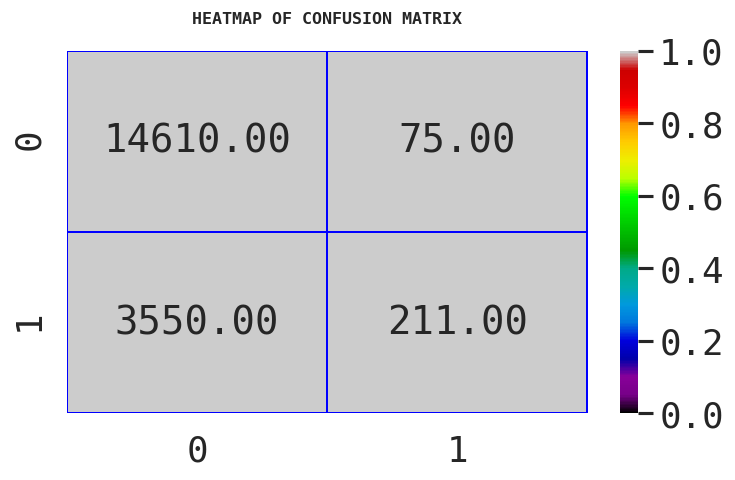



Processing 5
-------------------------------------
ACCURACY SCORE: 0.8109075138241353

F1 score: 0.1505114466634194

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.81      0.99      0.89     14793
           1       0.68      0.08      0.15      3653

    accuracy                           0.81     18446
   macro avg       0.75      0.54      0.52     18446
weighted avg       0.79      0.81      0.75     18446


PRECISION:
 0.6821192052980133

RECALL:
 0.08458800985491377

MEAN SQUARED ERROR:
 0.1890924861758647

ROOT MEAN SQ. ERROR:
 0.4348476585838593

LOG_LOSS: 6.531029340099665

AUC_ROC Score:
 0.5374268380241919

TPR: [0.         0.00973433 1.        ] 
FPR: [0.         0.08458801 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



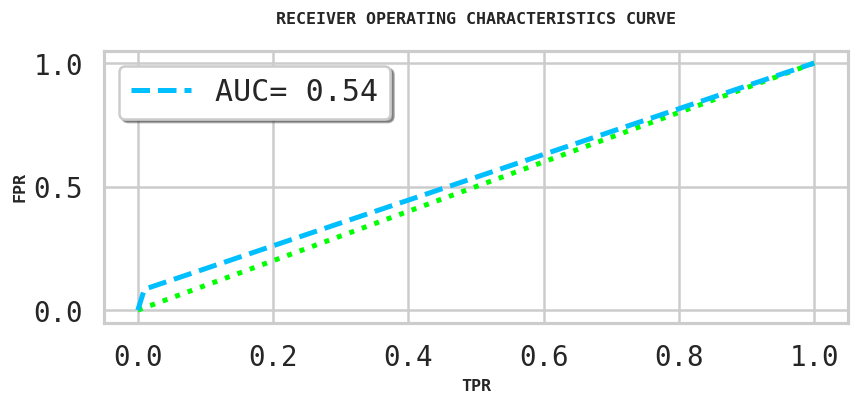





	____________________________________________CONFUSION MATRIX___________________________________________



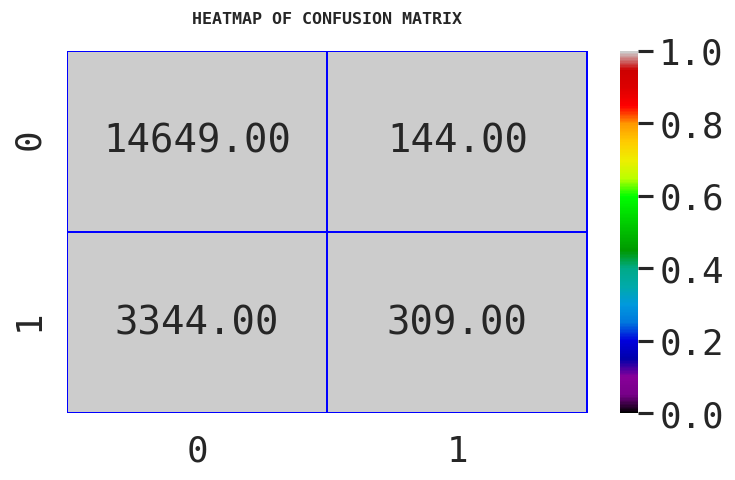

In [65]:
mnb_pipeline = Pipeline([('clf', OneVsRestClassifier(MultinomialNB(), n_jobs=1))])
F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]

for category in labels:
    print('Processing {}'.format(category))
    print('-------------------------------------')
    mnb_pipeline.fit(x_train, y_train[category])
    pred = mnb_pipeline.predict(x_test)
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
        

    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr)
    
    print('\n')
    #plotting the auc_roc curve
    print('\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')
    print()
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
    #plotting confusion matrix
    print('\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1.3)
    plt.figure(figsize=(7,4),dpi=120)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
    
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)
    


In [66]:
#creating a dataframe to show the performance of the model

mnb_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
                               
mnb_results.style.set_properties(**{'background-color':'white','color': 'black','border-color': 'black'})

,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,1,0.237124,0.803264,0.522706,0.153344,0.443550,0.196736,0.559236,6.795058
1,2,0.251171,0.818009,0.642694,0.156085,0.426604,0.181991,0.567496,6.285749
2,3,0.148329,0.810745,0.863636,0.081132,0.435035,0.189255,0.538933,6.536642
3,4,0.104275,0.803480,0.737762,0.056102,0.443305,0.196520,0.525497,6.787549
4,5,0.150511,0.810908,0.682119,0.084588,0.434848,0.189092,0.537427,6.531029


In [68]:
#printing all the dataframe at one place

print('\nRESULTS OBTAINED FROM LOGISTIC REGRESSION\n')
display(logi_results)
print('\nRESULTS OBTAINED FROM KNeighborsClassifierR\n')
display(knn_results)
print('\nRESULTS OBTAINED FROM MULTINOMIAL NB\n')
display(mnb_results)
print('\nRESULTS OBTAINED FROM  BernoulliNB\n')
display(dt_results)
print('\nRESULTS OBTAINED FROM LINER SVC\n')
display(lsvc_results)
print('\nRESULTS OBTAINED FROM RandomForestClassifier\n')
display(Rf_results)



RESULTS OBTAINED FROM LOGISTIC REGRESSION



,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,1,0.268391,0.822075,0.745050,0.163676,0.421811,0.177925,0.574863,6.145312
1,2,0.416000,0.849615,0.864392,0.273912,0.387795,0.150385,0.631733,5.194117
2,3,0.275343,0.822509,0.806744,0.165999,0.421297,0.177491,0.577931,6.130330
3,4,0.178638,0.809064,0.726755,0.101835,0.436962,0.190936,0.546014,6.594692
4,5,0.348996,0.824244,0.654861,0.237887,0.419233,0.175756,0.603463,6.070426



RESULTS OBTAINED FROM KNeighborsClassifierR



,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,1,0.644235,0.867017,0.690395,0.603861,0.364668,0.132983,0.768209,4.593105
1,2,0.743305,0.889841,0.682757,0.815636,0.331903,0.110159,0.861757,3.804830
2,3,0.689344,0.873252,0.686425,0.692287,0.356017,0.126748,0.805835,4.377784
3,4,0.523526,0.844085,0.694505,0.420101,0.394860,0.155915,0.686387,5.385128
4,5,0.254623,0.809877,0.569392,0.163975,0.436030,0.190123,0.566676,6.566619



RESULTS OBTAINED FROM MULTINOMIAL NB



,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,1,0.237124,0.803264,0.522706,0.153344,0.443550,0.196736,0.559236,6.795058
1,2,0.251171,0.818009,0.642694,0.156085,0.426604,0.181991,0.567496,6.285749
2,3,0.148329,0.810745,0.863636,0.081132,0.435035,0.189255,0.538933,6.536642
3,4,0.104275,0.803480,0.737762,0.056102,0.443305,0.196520,0.525497,6.787549
4,5,0.150511,0.810908,0.682119,0.084588,0.434848,0.189092,0.537427,6.531029



RESULTS OBTAINED FROM  BernoulliNB



,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,1,0.666573,0.871679,0.691611,0.643284,0.358219,0.128321,0.785923,4.432079
1,2,0.801678,0.923127,0.808919,0.794566,0.277260,0.076873,0.874472,2.655130
2,3,0.720911,0.892334,0.761354,0.684548,0.328124,0.107666,0.814925,3.718674
3,4,0.580090,0.843814,0.641935,0.529115,0.395203,0.156186,0.726764,5.394508
4,5,0.546247,0.842025,0.633442,0.480153,0.397460,0.157975,0.705770,5.456294



RESULTS OBTAINED FROM LINER SVC



,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,1,0.499820,0.849398,0.739872,0.377379,0.388074,0.150602,0.672167,5.201622
1,2,0.697429,0.900466,0.859813,0.586637,0.315490,0.099534,0.781694,3.437790
2,3,0.552846,0.859861,0.785644,0.426475,0.374351,0.140139,0.698406,4.840241
3,4,0.358237,0.816058,0.620577,0.251795,0.428885,0.183942,0.606183,6.353168
4,5,0.470588,0.839965,0.682267,0.359157,0.400043,0.160035,0.658927,5.527429



RESULTS OBTAINED FROM RandomForestClassifier



,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,1,0.741767,0.909032,0.854610,0.655247,0.301609,0.090968,0.813742,3.141949
1,2,0.865325,0.950287,0.920050,0.816745,0.222963,0.049713,0.899747,1.717026
2,3,0.772277,0.917706,0.881809,0.686950,0.286870,0.082294,0.831739,2.842358
3,4,0.629929,0.875854,0.803049,0.518213,0.352344,0.124146,0.742832,4.287877
4,5,0.481596,0.845007,0.713212,0.363537,0.393691,0.154993,0.663719,5.353290


### Hyper Parameter Tuning

### Applying Hyper Parameter Tuning On Best fit Model

### Random Forest Classifier

In [74]:
#Hyper Parameter Tuning
paramgrid={'max_depth': [2,3,5],'max_features':['auto'],'n_estimators' :[100,200],'criterion':['entropy']}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid=paramgrid, cv=5, n_jobs=-1) 
grid_search.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': [2, 3, 5],
                         'max_features': ['auto'], 'n_estimators': [100, 200]})

In [75]:
print(grid_search.best_params_)

{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 200}


Processing 1
-------------------------------------
ACCURACY SCORE: 0.8335682532798439

F1 score: 0.29972627737226276

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91     14768
           1       0.93      0.18      0.30      3678

    accuracy                           0.83     18446
   macro avg       0.88      0.59      0.60     18446
weighted avg       0.85      0.83      0.78     18446


PRECISION:
 0.9305949008498584

RECALL:
 0.17862969004893964

MEAN SQUARED ERROR:
 0.16643174672015612

ROOT MEAN SQ. ERROR:
 0.4079604720069778

LOG_LOSS: 5.748351009034472

AUC_ROC Score:
 0.5876558526084351

TPR: [0.         0.00331798 1.        ] 
FPR: [0.         0.17862969 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



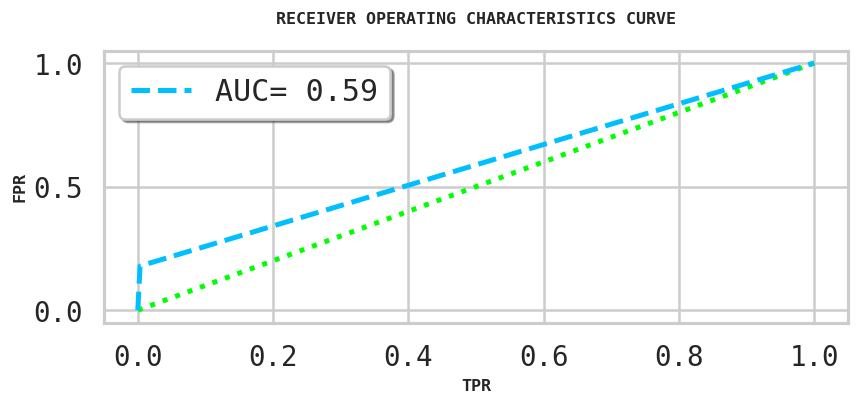





	____________________________________________CONFUSION MATRIX___________________________________________



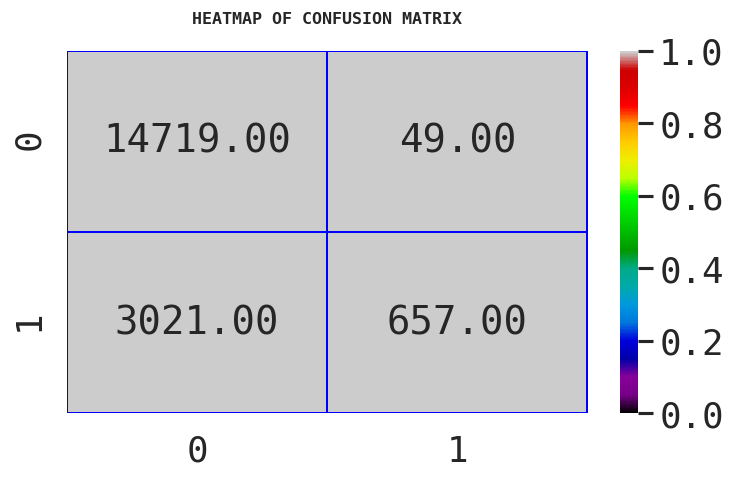



Processing 2
-------------------------------------
ACCURACY SCORE: 0.8570963894611298

F1 score: 0.4367521367521367

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92     14839
           1       0.95      0.28      0.44      3607

    accuracy                           0.86     18446
   macro avg       0.90      0.64      0.68     18446
weighted avg       0.87      0.86      0.82     18446


PRECISION:
 0.9524697110904008

RECALL:
 0.28333795397837536

MEAN SQUARED ERROR:
 0.1429036105388702

ROOT MEAN SQ. ERROR:
 0.37802593897624304

LOG_LOSS: 4.935718061176055

AUC_ROC Score:
 0.639950532350061

TPR: [0.         0.00343689 1.        ] 
FPR: [0.         0.28333795 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



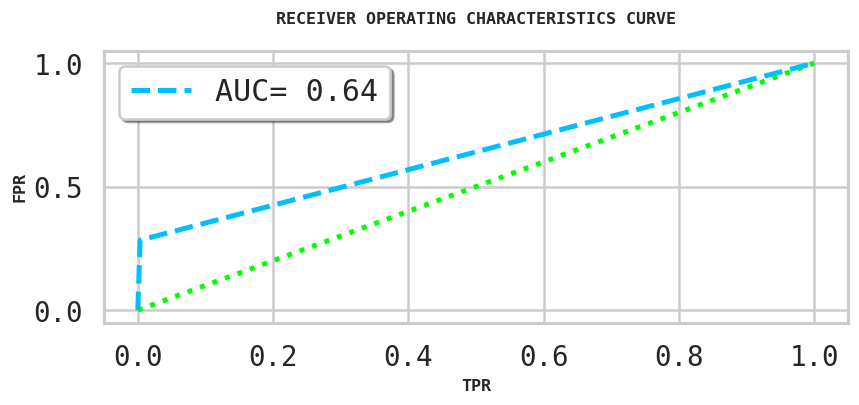





	____________________________________________CONFUSION MATRIX___________________________________________



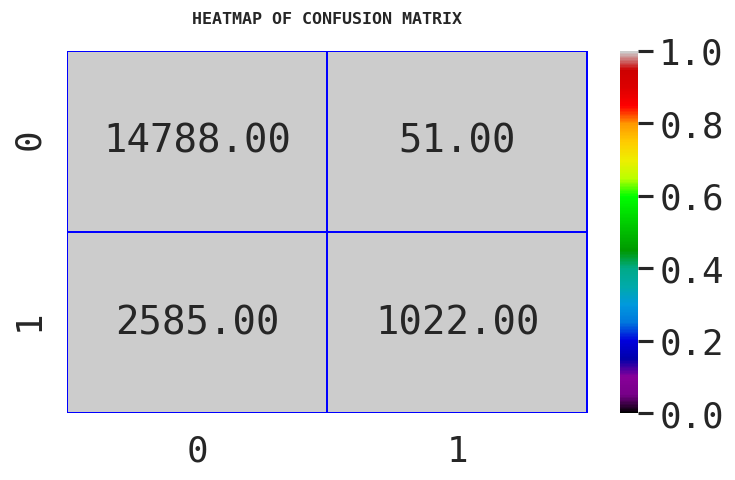



Processing 3
-------------------------------------
ACCURACY SCORE: 0.8263038057031334

F1 score: 0.2691605839416058

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90     14699
           1       0.93      0.16      0.27      3747

    accuracy                           0.83     18446
   macro avg       0.87      0.58      0.59     18446
weighted avg       0.84      0.83      0.77     18446


PRECISION:
 0.9262166405023547

RECALL:
 0.15745930077395248

MEAN SQUARED ERROR:
 0.17369619429686653

ROOT MEAN SQ. ERROR:
 0.41676875398338886

LOG_LOSS: 5.999256052822999

AUC_ROC Score:
 0.577130902172812

TPR: [0.        0.0031975 1.       ] 
FPR: [0.        0.1574593 1.       ]




	____________________________________________ROC_AUC CURVE_______________________________________________



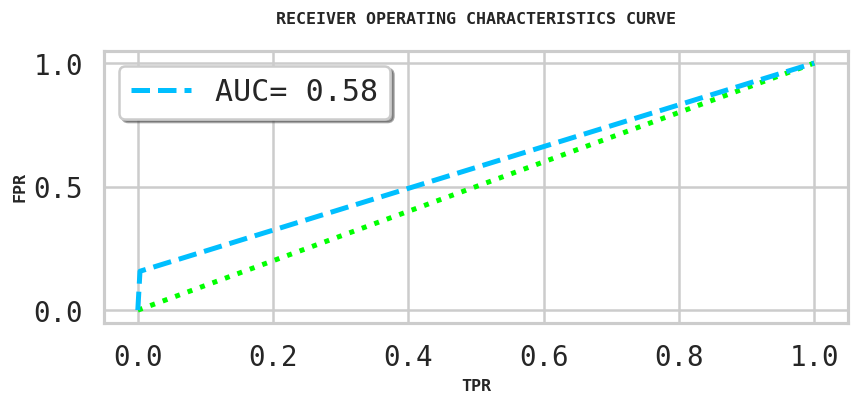





	____________________________________________CONFUSION MATRIX___________________________________________



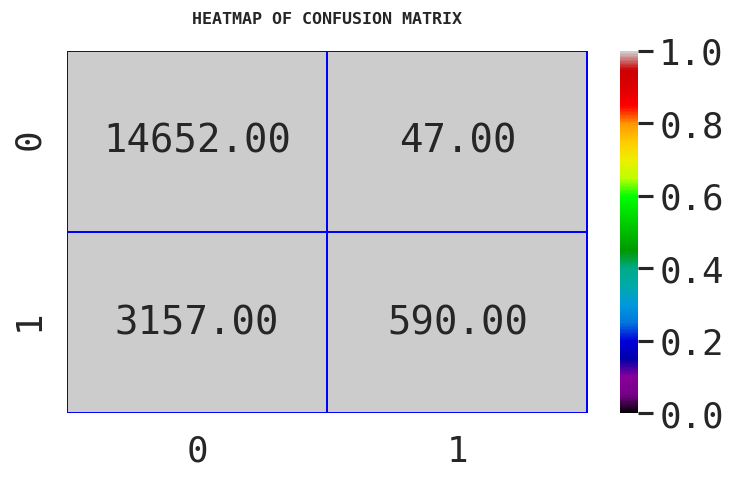



Processing 4
-------------------------------------
ACCURACY SCORE: 0.8102569662799523

F1 score: 0.14215686274509803

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.81      1.00      0.89     14685
           1       0.91      0.08      0.14      3761

    accuracy                           0.81     18446
   macro avg       0.86      0.54      0.52     18446
weighted avg       0.83      0.81      0.74     18446


PRECISION:
 0.9090909090909091

RECALL:
 0.07710715235309758

MEAN SQUARED ERROR:
 0.1897430337200477

ROOT MEAN SQ. ERROR:
 0.43559503408561456

LOG_LOSS: 6.553493471241075

AUC_ROC Score:
 0.5375661740655511

TPR: [0.        0.0019748 1.       ] 
FPR: [0.         0.07710715 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



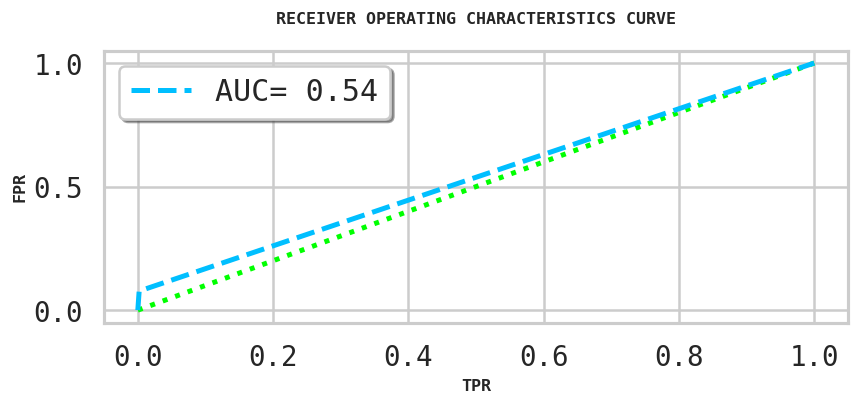





	____________________________________________CONFUSION MATRIX___________________________________________



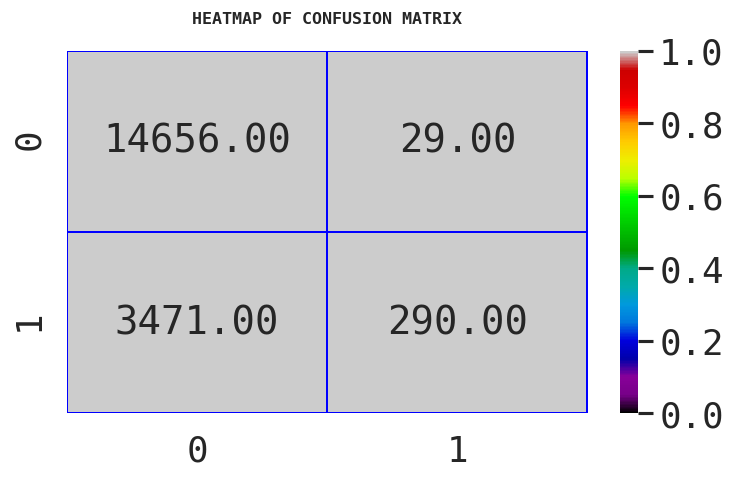



Processing 5
-------------------------------------
ACCURACY SCORE: 0.8290686327659114

F1 score: 0.32032765682259107

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.83      0.98      0.90     14793
           1       0.75      0.20      0.32      3653

    accuracy                           0.83     18446
   macro avg       0.79      0.59      0.61     18446
weighted avg       0.82      0.83      0.79     18446


PRECISION:
 0.7535496957403651

RECALL:
 0.2033944702983849

MEAN SQUARED ERROR:
 0.1709313672340887

ROOT MEAN SQ. ERROR:
 0.4134384684981414

LOG_LOSS: 5.9037708053414795

AUC_ROC Score:
 0.5934838909999327

TPR: [0.         0.01642669 1.        ] 
FPR: [0.         0.20339447 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



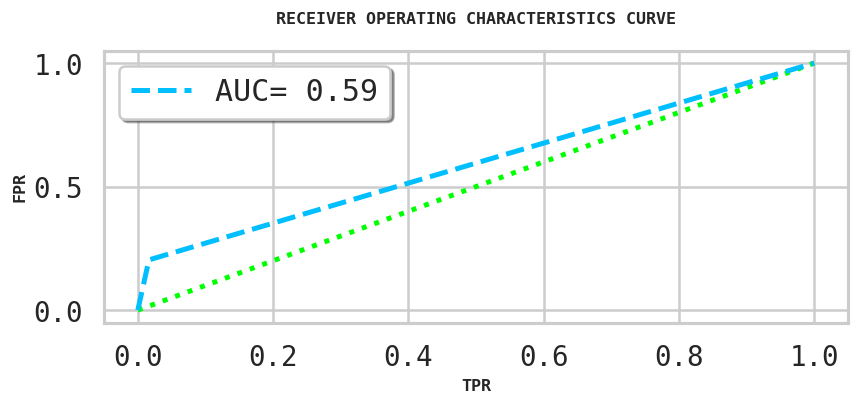





	____________________________________________CONFUSION MATRIX___________________________________________



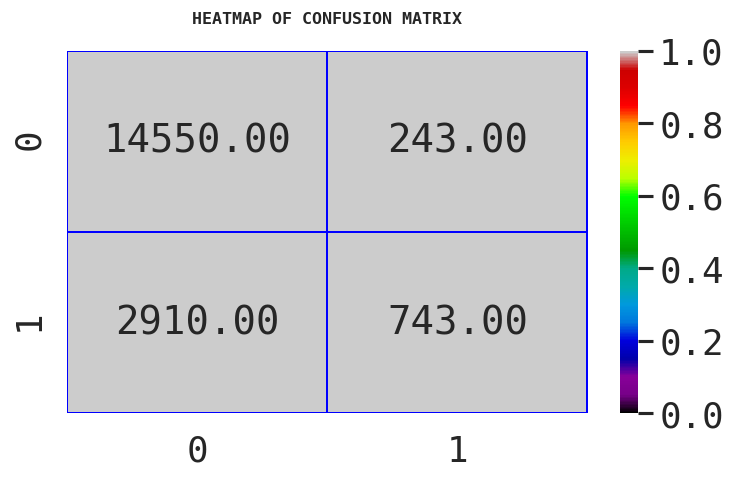

In [58]:
Rf_pipeline = Pipeline([('clf', OneVsRestClassifier(RandomForestClassifier(criterion= 'entropy', max_depth=30, max_features= 'auto', n_estimators=100), n_jobs=1))])
F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]

for category in labels:
    print('Processing {}'.format(category))
    print('-------------------------------------')
    Rf_pipeline.fit(x_train, y_train[category])
    pred = Rf_pipeline.predict(x_test)
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
        

    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr)
    
    print('\n')
    #plotting the auc_roc curve
    print('\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')
    print()
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
    #plotting confusion matrix
    print('\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1.3)
    plt.figure(figsize=(7,4),dpi=120)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
    
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)
    


In [68]:
#creating a dataframe to show the performance of the model

Rf_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
                               
Rf_results.style.set_properties(**{'background-color':'white','color': 'black','border-color': 'black'})

,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,1,0.754399,0.912989,0.862793,0.670201,0.294976,0.087011,0.821829,3.005261
1,2,0.880841,0.955763,0.930577,0.836152,0.210326,0.044237,0.910495,1.527910
2,3,0.774570,0.918302,0.881212,0.690953,0.285828,0.081698,0.833605,2.821762
3,4,0.610722,0.870487,0.788721,0.498272,0.359879,0.129513,0.732044,4.473248
4,5,0.492263,0.847013,0.718110,0.374487,0.391136,0.152987,0.669093,5.284010


Random Forest Classifier is performing best in terms of accuracy, AUC ROC Score, Log loss so am finailising the model Random Forest classifier to predict the ratings on the type of review. 

In [69]:
import pickle
filename = 'Ratings Prediction.pkl'
pickle.dump(Rf_pipeline,open(filename,'wb'))